In [1]:
# Imports and stable code

# Standard library imports
import time
import math
import copy
import os
os.environ["JULIA_NUM_THREADS"] = "6"
from julia.api import Julia
julia = Julia(sysimage="sysimage.so")
from julia import Main
Main.include("model.jl")

import shutil
from tempfile import NamedTemporaryFile
import multiprocessing
from collections import deque
import re
import sqlite3

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, basinhopping, differential_evolution, OptimizeResult
from scipy.stats import qmc
from joblib import Parallel, delayed


In [2]:
# Infrastructure functions

#ASA Optimizer

def vfsa_accprob(curr_cost, new_cost, temp_acc):
    exponent = np.clip((new_cost - curr_cost) / temp_acc, -500, 500)
    return 1 / (1 + np.exp(exponent))

def vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: 
        rng = np.random.default_rng()

    uni = rng.random(dim)
    base = 1 + 1 / (temp_gen + 1e-10)  # Small value added to avoid division by zero
    exponent = 2 * uni - 1
    rnd = np.sign(uni - 0.5) * temp_gen * (base**np.abs(exponent) - 1)
    return (log_ub - log_lb) * rnd

def vfsa_gen_params(curr_params, dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: 
        rng = np.random.default_rng()

    log_params = np.log10(curr_params)
    flag1 = True

    while flag1:
        # Generate a log step
        log_step = vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng)
        new_log_params = log_params + log_step

        # Check if all new parameters are within bounds
        if np.all(new_log_params >= log_lb) and np.all(new_log_params <= log_ub):
            # If within bounds, convert back to linear scale and return
            par = 10 ** new_log_params
            flag1 = False
        else:
            # If any parameter is out of bounds, handle each one individually
            for i in range(dim):
                if new_log_params[i] < log_lb[i] or new_log_params[i] > log_ub[i]:
                    flag2 = True
                    while flag2:
                        # Generate a new step for the out-of-bounds parameter
                        log_step = vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng)
                        new_log_params[i] = log_params[i] + log_step[i]

                        # Check if it's now within bounds
                        if log_lb[i] <= new_log_params[i] <= log_ub[i]:
                            flag2 = False

            # Once all parameters are adjusted, convert to linear scale and exit loop
            par = 10 ** new_log_params
            flag1 = False

    return par
        
def vfsa_generinitpoint(dim, log_lb, log_ub, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    # Ensure that bounds are valid (finite numbers)
    if not (np.all(np.isfinite(log_lb)) and np.all(np.isfinite(log_ub))):
        raise ValueError("Bounds must be finite numbers")
    
    # Ensure bounds have proper order: log_lb should be less than or equal to log_ub
    if np.any(log_lb > log_ub):
        raise ValueError("Lower bounds must be less than or equal to upper bounds")
    
    flag = True
    while flag:
        # Generate random uniform numbers for each dimension
        uni = rng.random(dim)
        
        # Calculate log_initpoints within the bounds
        log_initpoints = log_lb + (log_ub - log_lb) * uni
        
        # Check if the new points are within the bounds (they should be)
        if np.all(log_initpoints >= log_lb) and np.all(log_initpoints <= log_ub):
            flag = False
    
    # Return the initial points, exponentiated back from log scale to original scale
    return 10 ** log_initpoints

def vfsa_reannealing(best_cost, best_params, curr_cost, dim, x0, tmax, tscat, data, c, temp_gen, temp0_gen, objective_function):
    log_orig_best_params = np.log10(best_params)
    log_par_delta = log_orig_best_params + 0.01 * log_orig_best_params
    par_delta = 10 ** log_par_delta
    
    cost_delta = np.array([
        objective_function(par_delta if i == j else best_params)
        for j in range(dim)
    ])
    
    par_diff = np.clip(par_delta - best_params, 1e-10, None)  # Avoid division by zero
    s = np.abs((cost_delta - best_cost) / par_diff) * (best_params / best_cost)
    smax = np.max(s)
    
    temp_gen = np.clip(temp_gen * (smax / np.clip(s, 1e-10, None)), 1e-10, None)
    
    k_gen = (-1/c * np.log(np.clip(temp_gen / temp0_gen, 1e-10, None))) ** dim
    k_gen = np.clip(k_gen, 0, None)  # Ensure non-negative values
    
    temp0_acc = curr_cost
    temp_acc = best_cost
    k_acc = (-1/c * np.log(np.clip(temp_acc / temp0_acc, 1e-10, None))) ** dim
    
    return temp_gen, k_gen, temp0_acc, temp_acc, k_acc

def vfsa_temp(temp_gen0, c, k_gen, dim, min_temp=1e-10):
    exponent = -c * np.power(k_gen, 1/dim)
    temp = temp_gen0 * np.exp(exponent)
    return np.clip(temp, min_temp, None)

def simulated_annealing(objective_function, initial_solution, lower_bounds, upper_bounds, 
                        initial_temperature, cooling_rate, max_iterations, neighborhood_function, 
                        log_lb, log_ub, temp_gen, 
                        M=10, eps=0.0, min_temp=1e-10, verbose=False):
    
    current_solution = initial_solution
    current_cost = objective_function(current_solution)
    best_solution = current_solution
    best_cost = current_cost
    temperature = initial_temperature

    reanneal_cost_vec = [best_cost]
    diff = deque(maxlen=M)
    best_diff = deque(maxlen=M)
    count_acc_points = 0

    for iteration in range(max_iterations):
        # Generate a new solution in the neighborhood
        new_solution = neighborhood_function(current_solution, len(current_solution), log_lb, log_ub, temp_gen)
        new_cost = objective_function(new_solution)
        delta_cost = new_cost - current_cost
        
        # Acceptance probability
        if delta_cost < 0 or np.random.rand() < np.exp(-delta_cost / temperature):
            current_solution = new_solution
            current_cost = new_cost
            count_acc_points += 1
            
            # Update the best solution found
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

            # Reannealing: Store the best cost at this point
            reanneal_cost_vec.append(best_cost)
            if len(reanneal_cost_vec) > 1:
                diff.append(abs(reanneal_cost_vec[-1] - reanneal_cost_vec[-2]))
                best_diff.append(abs(reanneal_cost_vec[-1] - best_cost))

                # Termination condition based on the last M accepted costs
                if len(diff) == M and all(d <= eps for d in diff) and all(bd <= eps for bd in best_diff):
                    print('ASA converged, terminating at', iteration)
                    break
        
        # Decrease the temperature with a check for minimum temperature
        temperature = max(min_temp, temperature * cooling_rate)
        
        # Progress print statements
        if verbose and iteration % (max_iterations // 10) == 0:
            print(f"Iteration {iteration}: Current cost = {current_cost}, Best cost = {best_cost}")
            print(f"Current solution: {current_solution}")
        
    return best_solution, best_cost

def ASA(objective_function, x0, bounds, maxiter=100, initial_temp=1.0, cooling_rate=0.95, 
        neighborhood_function=vfsa_gen_params, init_function=vfsa_generinitpoint, 
        **kwargs):
    
    dim = len(x0)
    lower_bounds, upper_bounds = np.array(bounds).T
    log_lb, log_ub = np.log10(lower_bounds), np.log10(upper_bounds)
    log_bounds = list(zip(log_lb, log_ub))
    
    # Generate the initial solution
    initial_solution = init_function(dim, log_lb, log_ub)
    
    # Run ASA optimization
    best_solution, best_cost = simulated_annealing(
        objective_function, initial_solution, lower_bounds, upper_bounds,
        initial_temp, cooling_rate, maxiter, neighborhood_function,
        log_lb, log_ub, initial_temp, verbose=True,
        **kwargs
    )
    print('ASA best cost:', best_cost)
    print(best_solution)

    # After simulated annealing, refine the solution with a local optimizer (e.g., L-BFGS-B)
    minimizer_kwargs = {
        'method': 'L-BFGS-B',
        'bounds': bounds,
        'options': {
            'disp': True,
            'maxiter': 250,
        }
    }

    local_result = minimize(
        objective_function,
        x0=best_solution,
        **minimizer_kwargs
    )
    
    final_solution = local_result.x
    final_cost = local_result.fun
    nfev = local_result.nfev
    success = local_result.success

    return OptimizeResult(x=final_solution, fun=final_cost, nfev=nfev, success=success)

class TimeManager:
    def __init__(self):
        self.start_time = time.time()

    def check_timeout(self, timeout: int) -> bool:
        return (time.time() - self.start_time) > timeout

    def reset_start_time(self):
        self.start_time = time.time()

    def get_elapsed_time(self) -> float:
        return time.time() - self.start_time

def unique_colors(ids):
    num_colors = len(ids)
    colors = sns.color_palette("husl", num_colors)
    return dict(zip(ids, colors))

class NoOpMinimizer:
    def __call__(self, x):
        return x

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    
    # Define the replacements
    replacements = {
        r"\bd_E\b": "dₑ",  # d_E -> d subscript E
        r"\bdelta_E\b": "δₑ",  # delta_E -> δ subscript E
        r"\bK_delta_E\b": "K₍δₑ₎",  # K_delta_E -> K subscript δ subscript E
        r"\btau\b": "τ",  # tau -> τ
        r"\bxi\b": "ξ",  # xi -> ξ
        r"\bbeta\b": "β",  # beta -> β
    }

    # Apply the replacements using regex
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)

    return fit_params_str

def plot(results, subplot_config, group=True, title=None, save=True):
    
    t_span = [0, 8]
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    

    # Determine the number of rows and columns based on the number of subplots
    if n_subplots <= 3:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))

    if group:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
        axs_flat = axs.flatten()
    
    base_font_size = 14

    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9
    text_font_size = base_font_size * 1.0

    fit_params = {
        103: {'slope': -0.2107, 'intercept': 5.9919, 'start': 2, 'end': 6},
        107: {'slope': -0.3989, 'intercept': 7.3109, 'start': 3, 'end': 6},
        110: {'slope': -0.4535, 'intercept': 6.3292, 'start': 2, 'end': 5},
        111: {'slope': -0.1783, 'intercept': 5.8516, 'start': 2, 'end': 7},
        204: {'slope': -0.9055, 'intercept': 6.3424, 'start': 2, 'end': 4},
        207: {'slope': -0.492, 'intercept': 7.045, 'start': 2, 'end': 4},
        301: {'slope': -0.4196, 'intercept': 8.3419, 'start': 2, 'end': 5},
        302: {'slope': -0.6903, 'intercept': 8.5783, 'start': 2, 'end': 5},
        307: {'slope': -0.5197, 'intercept': 7.9866, 'start': 2, 'end': 5},
        308: {'slope': -0.2045, 'intercept': 6.1577, 'start': 2, 'end': 6},
        311: {'slope': -2.4543, 'intercept': 10.1, 'start': 2, 'end': 3},
        312: {'slope': -0.8099, 'intercept': 9.8591, 'start': 4, 'end': 6},
    }

    impute_params = {
        101: {'imputed': 1, 'val': 6667},
        110: {'imputed': [1, 2], 'val': [6667, 171203]},
        111: {'imputed': [1, 2], 'val': [6667, 171203]},
        112: {'imputed': [1, 2], 'val': [6667, 171203]},
        204: {'imputed': 1, 'val': 6667},
        207: {'imputed': 1, 'val': 6667}
    }

    fit_params_set = set()
    for result, patient in results:
        patient_id = patient.id
        # Get only the parameters that were fit
        fit_parameters = [param_name for param_name, param in patient.parameters._parameters.items() if param.method == 'fit']
        fit_params_set.update(fit_parameters)

        if not group:
            if title is None:
                fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""
            else:
                fit_params_str = format_fit_params(title)
            title_str = f"Patient {patient_id}{': ' + fit_params_str if fit_params_str else ''}"
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
            axs_flat = axs.flatten()
            fig.suptitle(title_str, fontsize=title_font_size)

        # Extract the SSE for 'V' and 'CD8TE'
        v_sse = None
        cd8te_sse = None

        for idx, state in enumerate(patient.states):
            state_label = state['label']
            if state_label == 'V':
                v_sse = patient.sse_statewise[idx]
            elif state_label == 'CD8TE':
                cd8te_sse = patient.sse_statewise[idx]

        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]
            ax.set_title(config['title'], fontsize=title_font_size)

            if config['data_key']:
                if isinstance(patient_id, str) and patient_id=='Population':
                    ids = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
                    volunteer_data = patient.df[patient.df['VOLUNTEER'].isin(ids)].copy()
                else:
                    volunteer_data = patient.df[patient.df['VOLUNTEER'].isin([patient_id])].copy()
                if config['data_scale'] is not None:
                    volunteer_data[config['data_key']] *= config['data_scale']
                
                ax.plot(volunteer_data['DAY'], np.log10(np.maximum(volunteer_data[config['data_key']], 1.0)),
                        marker='o', color=patient.color, linestyle='None', alpha=1.0, zorder=15)

                if not group and config['title'] == 'Virus' and patient_id in fit_params:
                    fit_param = fit_params[patient_id]
                    start, end = fit_param['start'], fit_param['end']
                    slope, intercept = fit_param['slope'], fit_param['intercept']

                    fitting_days = np.arange(start, end + 1)
                    fitting_data = slope * fitting_days + intercept
                    ax.plot(fitting_days, fitting_data, 'r--', zorder=16)

                    if patient_id in impute_params:
                        impute_data = impute_params[patient_id]
                        impute_days = np.array(impute_data['imputed'])
                        impute_vals = np.array(impute_data['val'])

                        ax.plot(impute_days, np.log10(np.maximum(impute_vals, 1)), marker='o', markersize=4, color='white', 
                                markeredgecolor='white', linestyle='None', alpha=1.0, zorder=25)

            if config['sol_key'] is not None and patient.sol:
                sol_t = patient.sol.t
                sol_y_raw = patient.sol.y[config['sol_key']]
                sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])

            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            ax.set_ylabel(f'log10 ({config["data_key"]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

            if not group:
                # Add the SSE to the plot for the relevant state
                #if config['title'] == 'Virus' and v_sse is not None:
                    #ax.text(0.95, 0.05, f'SSE: {v_sse:.4f}', transform=ax.transAxes, 
                            #verticalalignment='bottom', horizontalalignment='right', 
                            #fontsize=text_font_size, color='black')
                if config['title'] == 'CD8 T Effectors' and cd8te_sse is not None:
                    sse=v_sse+cd8te_sse
                    ax.text(0.95, 0.05, f'SSE: {sse:.4f}', transform=ax.transAxes, 
                            verticalalignment='bottom', horizontalalignment='right', 
                            fontsize=text_font_size, color='black')

        for j in range(i + 1, len(axs_flat)):
            axs_flat[j].set_visible(False)

        if not group:
            plt.tight_layout()
            save_dir = os.path.join('plots', f'Patient_{patient_id}')
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'{fit_params_str}.png')
            if save: plt.savefig(save_path, bbox_inches='tight')
            plt.show()

    if group:
        fit_params_str = "_".join(sorted(fit_params_set))
        title_str = f"All Patients - Parameters {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)
        
        plt.tight_layout()
        save_dir = os.path.join('plots', 'Grouped')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.png')
        if save: plt.savefig(save_path, bbox_inches='tight')
        plt.show()


In [3]:
# Curent development area 
class Parameter:
    def __init__(self, name, val=None, l_lim=None, u_lim=None, method='fixed', space='log10'):
        self.name = name
        self.space = space
        self.l_lim = self._transform_space(l_lim)
        self.u_lim = self._transform_space(u_lim)
        self.val = val
        self.method = method

    def _transform_space(self, bound):
        if self.space == 'log10':
            return np.log10(bound)
        elif self.space == 'normal':
            return bound

    def _inverse_transform_space(self, value):
        if self.space == 'log10':
            return 10 ** value
        elif self.space == 'normal':
            return value

    def __repr__(self):
        return f"{self.val:.2e}"

    def sweep(self, num_points=100):
        values = np.linspace(self.l_lim, self.u_lim, num=num_points)
        if self.space == 'log10':
            values = 10 ** values  # Inverse transform back to natural space
        return [self._convert_to_type(val) for val in values]

class Parameters:
    def __init__(self, **kwargs):
        self._parameters = kwargs

    def __getattr__(self, item):
        if item in self._parameters:
            return self._parameters[item]
        raise AttributeError(f"'Parameters' object has no attribute '{item}'")

    def __setattr__(self, key, value):
        if key == '_parameters':
            super().__setattr__(key, value)
        else:
            self._parameters[key] = value

    def __getstate__(self):
        return self._parameters

    def __setstate__(self, state):
        self._parameters = state

    def items(self):
        return self._parameters.items()

    def __repr__(self):
        return f"Parameters({', '.join([f'{k}={v}' for k, v in self._parameters.items()])})"

    def load_parameters_from_dataframe(self, df_params, patient_id):
        if patient_id not in df_params['id'].values:
            print(f"ID {patient_id} not found in parameter file.")
            return
        param_values = df_params[df_params['id'] == patient_id].iloc[0]
        for param_name, param_obj in self._parameters.items():
            if param_obj.method == 'file' and param_name in param_values:
                param_val = param_values[param_name]
                if not np.isnan(param_val):
                    param_obj.val = param_val
                else:
                    print(f"Parameter '{param_name}' for ID {patient_id} is missing in the parameter file. Falling back to original values.")

class State:
    def __init__(self, label: str, initial_value: float = 0.0, sse: bool = False, scale: float = 1.0):
        self.label = label
        self.initial_value = initial_value
        self.time_points = np.array([0.0])
        self.sse = sse
        self.scale = scale

    def __repr__(self):
        return f"State(label={self.label}, initial_value={self.initial_value}, sse={self.sse})"

class States:
    def __init__(self, states_config: list):
        self.states = {config['label']: State(**config) for config in states_config}
        self.state_labels = [state.label for state in self.states.values()]

    def __getattr__(self, name: str) -> float:
        return self.states[name].get_latest_value()

    def __repr__(self):
        return f"States({', '.join([f'{k}={v}' for k, v in self.states.items()])}, sse={self.sse})"
    
class Patient:
    def __init__(self, id, color, t_span, df, parameters, states, df_params=None, sol=None, solve_time=np.nan, sse=np.inf, sse_statewise=np.inf):
        self.id = id
        self.color = color
        self.t_span = t_span
        self.df = df
        self.parameters = parameters
        self.states = states
        self.sol = sol
        self.solve_time = solve_time
        self.sse = sse
        self.sse_statewise = sse_statewise

        if df_params is not None:
            self.parameters.load_parameters_from_dataframe(df_params, self.id)
        self.param_names = list(self.parameters._parameters.keys())
        self.results_in_memory = []  # To store results for later DB writes

    def solve(self):
        try:
            self.sol = JuliaSolve((
                self.parameters, self.states, self.t_span
            ))
        except Exception as e:
            self.sol = None
            print(f"Error solving patient {self.id}: {e}")
    
    def compare(self):
  
        weight_dict = {
            103: 11.941,
            107: 13.425,
            110: 5.305,
            111: 5.401,
            112: 7.765,
            204: 2.851,
            207: 7.264,
            302: 7.518,
            307: 6.584,
            308: 6.636,
            311: 4.948,
            312: 9.312,
            'Population': 6.2,
        }

        slopes = False
        df = self.df
        shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
        stats = ['Population']
        targets = [self.id]

        for pid in targets:
            #print(f'comparing {pid}')
                if isinstance(pid, str) and pid=='Population':
                    pid_df = df[df['VOLUNTEER'].isin(shedders)].copy()
                    pid_df['VOLUNTEER'] = 'Population'
                else:
                    pid_df = df[df['VOLUNTEER'].isin([pid])]#.copy()
                
                if slopes:
                    all_data_slopes = []
                    all_model_slopes = []
                sse_array = [0] * (len(self.states)+1)
                sse = 0

                for idx, state in enumerate(self.states):
                    state_label = state['label']
                    state_sse = 0
                    
                    if state_label == 'CD8TE' or state_label == 'V':
                        if state_label in pid_df.columns:
                            data_values = pid_df[state_label].values * state.get('scale', 1.0)
                            time_points = pid_df['DAY'].values
                            valid_indices = ~np.isnan(data_values)
                            data_values = data_values[valid_indices]
                            time_points = time_points[valid_indices]

                            weight = 1
                            #if state_label == 'V':
                                #weight = (1 / weight_dict[self.id])

                            if len(data_values) > 0:
                                model_time_points = self.sol.t
                                model_values = self.sol.y[idx]

                                if model_values.shape[0] != len(model_time_points):
                                    model_values = np.transpose(model_values)

                                interpolated_model_values = np.interp(time_points, model_time_points, model_values)

                                # Calculate SSE 
                                for i in range(len(time_points)):

                                    floor = 1.0
                                    data_at_t = data_values[i]
                                    model_at_t = interpolated_model_values[i]
                                    logdata = np.log10(np.maximum(data_at_t, floor))
                                    logmodel = np.log10(np.maximum(model_at_t, floor))
                                    error = (logmodel - logdata) ** 2
                                    state_sse += error
                                    if state.get('sse', True): sse += error * weight

                                    if slopes:
                                        # Collect slopes for all points except the last (forward slope)
                                        if state_label == 'CD8TE' and state.get('sse', True) and i < len(time_points) - 1:
                                            logdata_ti1 = np.log10(np.maximum(data_values[i + 1], floor))
                                            logmodel_ti1 = np.log10(np.maximum(interpolated_model_values[i + 1], floor))

                                            slope_data = logdata_ti1 - logdata
                                            slope_model = logmodel_ti1 - logmodel

                                            if np.isfinite(slope_data) and np.isfinite(slope_model):
                                                all_data_slopes.append(slope_data)
                                                all_model_slopes.append(slope_model)

                            sse_array[idx] = state_sse
                if slopes:
                    # After collecting all slopes, calculate SE3 and apply slope penalties
                    if len(all_data_slopes) > 0 and len(all_model_slopes) > 0:
                        max_slope_data = max(all_data_slopes)
                        min_slope_data = min(all_data_slopes)
                        Vdat = pid_df['V'].values
                        Vdat = Vdat[~np.isnan(Vdat)]
                        SE3 = np.log10(max(Vdat)) / (max_slope_data - min_slope_data)
                        #print('Final Slope weight', SE3, flush=True)

                        for model_slope, data_slope in zip(all_model_slopes, all_data_slopes):
                            slope_penalty = 0.5 * SE3 * (model_slope - data_slope) ** 2
                            sse_array[-1] += slope_penalty

                self.sse = sse
                self.sse_statewise = sse_array
                    
                sse_statewise_db = sse_array
                V_sse_db = sse_statewise_db[3]
                C_sse_db = sse_statewise_db[4]
                sse_db = V_sse_db + C_sse_db

                # Store the parameters and SSEs in memory (defer DB writes)
                all_params = [param.val for param in self.parameters._parameters.values()]
                self.results_in_memory.append((all_params, [V_sse_db, C_sse_db, sse_db], str(pid)))

        return self.sse, self.sse_statewise
    
    def objective_function(self, x):
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**x[i]
            else:
                self.parameters._parameters[name].val = x[i]

        self.solve()
        self.compare()

        return self.sse
    
    def write_results_to_db(self, path):
        conn = sqlite3.connect(path)
        cursor = conn.cursor()
        cursor.executemany('''
            INSERT INTO evaluations (
                E0, T0, I10, beta, k, p, c, delta, xi, a, d_E, delta_E, K_delta_E,
                V_sse, C_sse, sse, PID
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', [tuple(p) + tuple(e) + (pid,) for p, e, pid in self.results_in_memory])
        conn.commit()
        conn.close()
        self.results_in_memory = [] # Flush the results from memory
        print(f'Results saved to {path}.',flush=True)

    def optimize_parameters(self, method='halton', iter=1000, verbose=False, path='output', local_iter=1000, local_method='L-BFGS-B'):
        fit_parameters = {name: param for name, param in self.parameters._parameters.items() if param.method == 'fit'}

        if not fit_parameters:
            print("No parameters to optimize")
            self.solve()
            self.compare()
            return (None, self)

        
        #initial_values = [np.log10(param.val) if param.space == 'log10' else param.val for param in fit_parameters.values()]
        initial_values = []
        for param in fit_parameters.values():
            sampled_value = np.random.uniform(param.l_lim, param.u_lim)
            if param.space == 'log10':
                initial_values.append(10**sampled_value)
            else:
                initial_values.append(sampled_value)

        bounds = [(param.l_lim, param.u_lim) for param in fit_parameters.values()]
        self.param_names = list(fit_parameters.keys())  # Save param_names as instance variable
        number_fit = len(self.param_names)

        minimizer_kwargs = {
            'method': local_method,
            'bounds': bounds,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': verbose,
                    'maxiter': local_iter,
            }}

        if method == 'differential_evolution':
            def split_iters(iters):
                sqrt_iters = math.sqrt(iters)
                pop_size = round(sqrt_iters)
                generations = round(iters / pop_size)
                
                return pop_size, generations

            pop_size, generations = split_iters(iter)
            print(f'{self.id} Differential Evolution with pop size:{pop_size}, generations:{generations}',flush=True)
            # Single instance of DE in serial
            result = differential_evolution(
                self.objective_function,
                bounds=bounds,
                strategy='best1bin',
                maxiter=generations,
                popsize=pop_size,
                mutation=(0.2, 0.9),
                recombination=0.9,
                seed=None,
                disp=verbose,
                polish=False,
                init='halton',
                workers=1, 
                vectorized=False
            )
        
        elif method == 'ASA':
            result = ASA(
                self.objective_function,
                x0=initial_values, 
                bounds=bounds,
                maxiter=iter,
                initial_temp=1.0,
                cooling_rate=0.95,
                neighborhood_function=vfsa_gen_params,
                init_function=vfsa_generinitpoint,
                M=15,  # Number of accepted costs for convergence
                eps=1e-6
            )
        
        elif method == 'basin_hopping':
            class BoundedStep:
                def __init__(self, fit_parameters, stepsize=0.5, normal_sampling=False):
                    self.fit_parameters = fit_parameters
                    self.stepsize = stepsize
                    self.normal_sampling = normal_sampling
                    self.precomputed = {}

                    for i, (param_name, param) in enumerate(self.fit_parameters.items()):
                        lower, upper = param.l_lim, param.u_lim
                        if param.space == 'log10':
                            lower, upper = np.log10(lower), np.log10(upper)

                        self.precomputed[i] = {
                            'lower': lower,
                            'upper': upper,
                            'range': upper - lower,
                            'is_log': param.space == 'log10'
                        }

                def __call__(self, x):
                    rng = np.random.default_rng()

                    for i in range(len(x)):
                        bounds = self.precomputed[i]
                        lower, upper, range_, is_log = bounds['lower'], bounds['upper'], bounds['range'], bounds['is_log']

                        if self.normal_sampling:
                            # Sample from a normal distribution, transform to [0, 1], then to desired range
                            step = rng.normal(0, self.stepsize)  # Step in standard normal space
                            step = np.clip(step, -3, 3)  # Clip to a range that mostly falls within [-3, 3] std devs
                            normalized_step = (step + 3) / 6  # Map from [-3, 3] to [0, 1]
                        else:
                            # Uniform sampling in [0, 1]
                            normalized_step = rng.uniform()

                        # Transform normalized step to the target range
                        step = (normalized_step - 0.5) * self.stepsize * range_

                        # Apply step and clip to the transformed bounds
                        x[i] = np.clip(x[i] + step, lower, upper)

                        # Transform back to the original space if necessary
                        if is_log:
                            x[i] = 10 ** x[i]

                    return x

            print(f'{self.id} Basin Hopping with n = {iter}',flush=True)
            result = basinhopping(
                self.objective_function,  
                x0=initial_values,
                niter=iter,
                T=0.01,
                stepsize=1.0,
                minimizer_kwargs=minimizer_kwargs,
                take_step=BoundedStep(fit_parameters, stepsize=1.0),
                interval=1,
                disp=verbose,
                niter_success=2,
                seed=None,
                target_accept_rate=0.5,
                stepwise_factor=0.8,
            )
        
        elif method == 'halton':
            print(f'{self.id} Halton with n = {iter}', flush=True)
            # Halton sampling-based optimization
            sampler = qmc.Halton(d=number_fit)
            n_samples = iter  # Number of samples for Halton sequence
            step_size = n_samples // 20  # 5% of n_samples

            # Generate Halton samples in [0, 1] and scale them to the parameter bounds
            halton_samples = sampler.random(n_samples)
            scaled_samples = qmc.scale(halton_samples, [b[0] for b in bounds], [b[1] for b in bounds])
            best_sample = None
            best_sse = np.inf
            progress_count = 0

            for i, sample in enumerate(scaled_samples):
                sse = self.objective_function(sample)
                if sse < best_sse:
                    best_sse = sse
                    best_sample = sample

                # Print progress every 5% 
                if (i + 1) % step_size == 0:
                    progress_count += 5
                    print(f"Progress: {progress_count}% of samples evaluated ({i+1}/{n_samples})")

            # Assign the best-found parameters back to the model
            result = OptimizeResult()
            result.x = best_sample
            result.fun = best_sse
        
        else: # Local solver fallback 
            fallback_minimizer_kwargs = {
            'method': local_method,
            'bounds': bounds,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': True,
                    'maxiter': iter,
            }}
            print(f'{self.id} {local_method} with n = {iter}',flush=True)
            result = minimize(
                self.objective_function, 
                x0=initial_values,
                **fallback_minimizer_kwargs
            )

        # Write results to database
        db_path = f'sql/{path}.db'
        os.makedirs('sql', exist_ok=True)
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS evaluations (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                E0 REAL, T0 REAL, I10 REAL, beta REAL, k REAL,
                p REAL, c REAL, delta REAL, xi REAL, a REAL,
                d_E REAL, delta_E REAL, K_delta_E REAL,
                V_sse REAL, C_sse REAL, sse REAL, PID REAL
            )
        ''')
        conn.commit()
        conn.close()
        self.write_results_to_db(path=db_path)

        # Final update of parameters
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**result.x[i]
            else:
                self.parameters._parameters[name].val = result.x[i]
            print(f'Parameter {name}: {self.parameters._parameters[name].val}')

        # Solve and compare with the best-found parameters
        self.solve()
        self.results_in_memory = []
        Main.GC.gc()

        return (result, self)
    
    def __repr__(self):
        return f"Patient({self.id}, sse={self.sse}, parameters={self.parameters})"

class Patients:
    def __init__(self, ids, df, t_span, parameters, states, parameter_file=None):
        self.color_dict = unique_colors(ids)
        t_fill = np.linspace(t_span[0], t_span[-1], 250)
        t_int = np.arange(t_span[0], t_span[-1] + 1)
        self.t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
        self.df = df
        self.parameters = parameters
        self.states = states
        # Load the parameters from the Excel file once
        if parameter_file:
            self.df_params = self.load_excel_parameters(parameter_file)
        else:
            print('No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.')
            self.df_params = None

        self.patients = {
            id: Patient(
                id,
                self.color_dict[id],
                self.t_span,
                self.df,
                copy.deepcopy(self.parameters),
                copy.deepcopy(self.states),
                self.df_params
            ) for id in ids
        }

        self.parameters.patients = self.patients

    def load_excel_parameters(self, parameter_file):
        parameter_file = os.path.abspath(parameter_file)
        df_params = None

        try:
            with NamedTemporaryFile(delete=False, suffix='.xlsx') as temp_file:
                temp_path = temp_file.name
                shutil.copyfile(parameter_file, temp_path)
            df_params = pd.read_excel(temp_path)

        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        finally:
            if os.path.exists(temp_path):
                os.remove(temp_path)

        return df_params

    def solve(self):
        for patient in self.patients.values():
            patient.solve()
            
    def compare(self, ids=None):
        if ids is None:
            ids = self.patients.keys()
        for patient_id in ids:
            self.patients[patient_id].compare()
    
    def optimize_parameters(self, opt_target, method, iter, path, verbose=False, local_iter=1000, local_method='L-BFGS-B'):
        results = []
        for patient in self.patients.values():
            if patient.id == opt_target:
                result = patient.optimize_parameters(method=method, iter=iter, verbose=verbose, path=path, local_iter=local_iter, local_method=local_method)
                results.append(result)

        return results
    
    def sweep_parameter(self, param_name, num_points=10, percentage_range=None):
        param_to_sweep = self.parameters._parameters.get(param_name)
        if param_to_sweep is None:
            raise ValueError(f"Parameter {param_name} not found.")
        
        print(f'Sweeping parameter: {param_name}')
        
        if percentage_range is not None:
            initial_value = param_to_sweep.val
            lower_bound = initial_value * (1 - percentage_range / 100)
            upper_bound = initial_value * (1 + percentage_range / 100)
            if param_to_sweep.space == 'log10':
                l_lim_transformed = np.log10(lower_bound)
                u_lim_transformed = np.log10(upper_bound)
                sweep_values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
                sweep_values = 10 ** sweep_values
            elif param_to_sweep.space == 'normal':
                sweep_values = np.linspace(lower_bound, upper_bound, num=num_points)
            else:
                raise ValueError(f"Unsupported space type: {param_to_sweep.space}")
        else:
            sweep_values = param_to_sweep.sweep(num_points)

        sweep_ids = [f'S{i}' for i in range(num_points)]

        def solve_for_value(i, value, patient):
            patient.parameters._parameters[param_name].val = value
            patient.solve()
            patient.compare()
            return patient

        num_cores = multiprocessing.cpu_count() - 1

        # Parallel execution across patients
        sweep_patients = []
        for patient in self.patients.values():
            results = Parallel(n_jobs=num_cores)(
                delayed(solve_for_value)(i, value, patient)
                for i, value in enumerate(sweep_values)
            )
            sweep_patients.extend(results)

        return sweep_patients, sweep_values

    def __getitem__(self, id):
        patient = self.patients.get(id, None)
        if patient is not None:
            return repr(patient)
        return None

    def __repr__(self):
        return '\n'.join(repr(patient) for patient in self.patients.values())

class JuliaODESolution:
    def __init__(self, t, y):
        self.t = np.array(t)  # Time points
        self.y = np.array(y)  # Transposed solution values (states over time)

    def __repr__(self):
        return f"JuliaODESolution(t={self.t}, y={self.y})"

def solve_with_julia(t_span, y0, params):
    t_span = (float(np.float64(t_span[0])), float(np.float64(t_span[-1])))
    y0 = [float(np.float64(val)) for val in y0]

    # Convert params from dict to a list (vector) in the correct order and ensure they are Float32
    params_julia = [
        float(np.float64(params["beta"])),
        float(np.float64(params["k"])),
        float(np.float64(params["delta"])),
        float(np.float64(params["delta_E"])),
        float(np.float64(params["K_delta_E"])),
        float(np.float64(params["p"])),
        float(np.float64(params["c"])),
        float(np.float64(params["xi"])),
        #float(np.float64(params["tau"])),
        float(np.float64(params["a"])),
        float(np.float64(params["d_E"]))
    ]
    # Call the Julia function
    t_values, y_values = Main.tmap_LCTModel(t_span, y0, params_julia)

    # Convert Julia arrays to NumPy arrays
    t_values = np.array(t_values, dtype=np.float64)
    y_values = np.array(y_values, dtype=np.float64)

    # Return the solution
    return JuliaODESolution(t=t_values, y=y_values)

def JuliaSolve(task):
    def inner_solve(param_set, states_config, t_span):
        states_config_copy = states_config.copy()
        # Prepare parameters and initial conditions for Julia
        params = {
            "beta": param_set.beta.val,
            "k": param_set.k.val,
            "delta": param_set.delta.val,
            "delta_E": param_set.delta_E.val,
            "K_delta_E": param_set.K_delta_E.val,
            "p": param_set.p.val,
            "c": param_set.c.val,
            "xi": param_set.xi.val,
            #"tau": param_set.tau.val,
            "a": param_set.a.val,
            "d_E": param_set.d_E.val  # Ensure this value is correct
        }

        # Debugging: Print updated parameters just before solving
        #print(f"Updated parameters being passed to Julia: {params}", flush=True)

        states_instance = States(states_config_copy)
        y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config])
        y0[0] = param_set.T0.val
        y0[1] = param_set.I10.val

        # Solve using Julia
        sol = solve_with_julia(t_span, y0, params)
        sol.y[4] += param_set.E0.val  # Add the background E0
        return sol

    sol = inner_solve(*task)
    return sol


In [4]:
# Shared setup
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
targets = ['Population']
ids = targets + shedders
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 0, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 2, '2nd_sol_key': None, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', '2nd_data_key': None, 'sol_key': 3, '2nd_sol_key': None, 'data_scale': None, 'ylims': [0,8]},
    {'title': 'CD8 T Effectors', 'data_key': 'CD8TE', '2nd_data_key': 'CD8TE', 'sol_key': 4, '2nd_sol_key': None, 'data_scale': None, 'ylims': [4.5,7.75]}, #[3E4,3E7]
    #{'title': 'CD8T Lung Cells', 'data_key': None, '2nd_data_key': None, 'sol_key': 5, '2nd_sol_key': None, 'data_scale': None, 'ylims': None},
]

n_Z = 13
states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TLung', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
t_span = (0.0, 8.0)
# Import data
df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='Tcens', usecols=list(range(0, 143)))
df = df[['VOLUNTEER', 'DAY', 'V', 'IFNY', 'CD8TE']]
df_Rahil = df.loc[df['DAY'] < 9]

In [6]:
# T cell decay regression
from scipy.stats import linregress

# Given data
data = {
    "VOLUNTEER": [110, 110, 307, 307, 307, 311, 311],
    "DAY": [6, 7, 5, 6, 7, 6, 7],
    "CD8TE": [1064415.324, 391862.0985, 2666592.101, 1147186.113, 365055.6525, 712155.912, 398236.7265],
    "LogCD8TE": [6.027111118, 5.59313326, 6.425956588, 6.059633881, 5.562359077, 5.852575084, 5.600141309]
}

df = pd.DataFrame(data)

# Group data by VOLUNTEER and estimate the decay rate d_E for each individual by linear regression of log(CD8TE) over time (DAY).
decay_rates = []
for volunteer, group in df.groupby('VOLUNTEER'):
    slope, _, _, _, _ = linregress(group['DAY'], group['LogCD8TE'])
    decay_rate = -slope * np.log(10)  # decay rate d_E is the negative of the slope
    decay_rates.append({"VOLUNTEER": volunteer, "Decay Rate (d_E)": decay_rate})

decay_rates_df = pd.DataFrame(decay_rates)
decay_rates_df

,VOLUNTEER,Decay Rate (d_E)
0,110,0.999271
1,307,0.994253
2,311,0.581250


Population Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 252.5414042555445
differential_evolution step 2: f(x)= 248.07673561168116
differential_evolution step 3: f(x)= 244.30651987178666
differential_evolution step 4: f(x)= 242.39870425197543
differential_evolution step 5: f(x)= 242.39870425197543
differential_evolution step 6: f(x)= 241.8155613676787
differential_evolution step 7: f(x)= 241.8155613676787
differential_evolution step 8: f(x)= 241.8155613676787
differential_evolution step 9: f(x)= 241.53466058896817
differential_evolution step 10: f(x)= 241.53466058896817
differential_evolution step 11: f(x)= 241.32292182271215
differential_evolution step 12: f(x)= 241.2979671488974
differential_evolution step 13: f(x)= 241.2979671488974
differential_evolution step 14: f(x)= 241.2979671488974
differential_evolution step 15: f(x)= 241.18009576296785
differential_evolution step 16: f(x)= 241.09807129408495
differential_evolution step 17: f(x

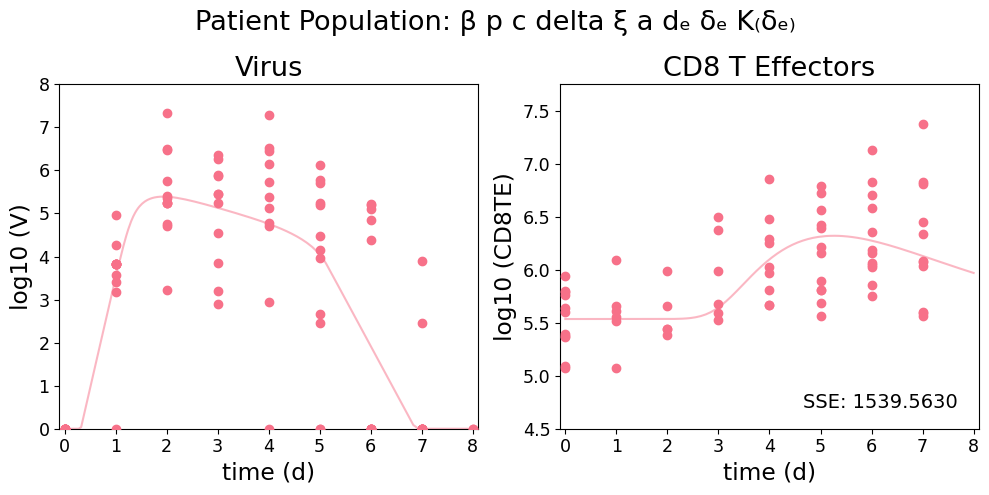

103 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 4.5997876712482135
differential_evolution step 2: f(x)= 2.862305310933536
differential_evolution step 3: f(x)= 2.691032186126916
differential_evolution step 4: f(x)= 2.436180115668856
differential_evolution step 5: f(x)= 2.1995534834711945
differential_evolution step 6: f(x)= 1.6794539419913457
differential_evolution step 7: f(x)= 1.6019273647293673
differential_evolution step 8: f(x)= 1.6019273647293673
differential_evolution step 9: f(x)= 1.5454506091493871
differential_evolution step 10: f(x)= 1.5454506091493871
differential_evolution step 11: f(x)= 1.5454506091493871
differential_evolution step 12: f(x)= 1.49321545149211
differential_evolution step 13: f(x)= 1.4740016750378784
differential_evolution step 14: f(x)= 1.4740016750378784
differential_evolution step 15: f(x)= 1.4740016750378784
differential_evolution step 16: f(x)= 1.4508724460054485
differential_evolution step 17: f(x)= 1.

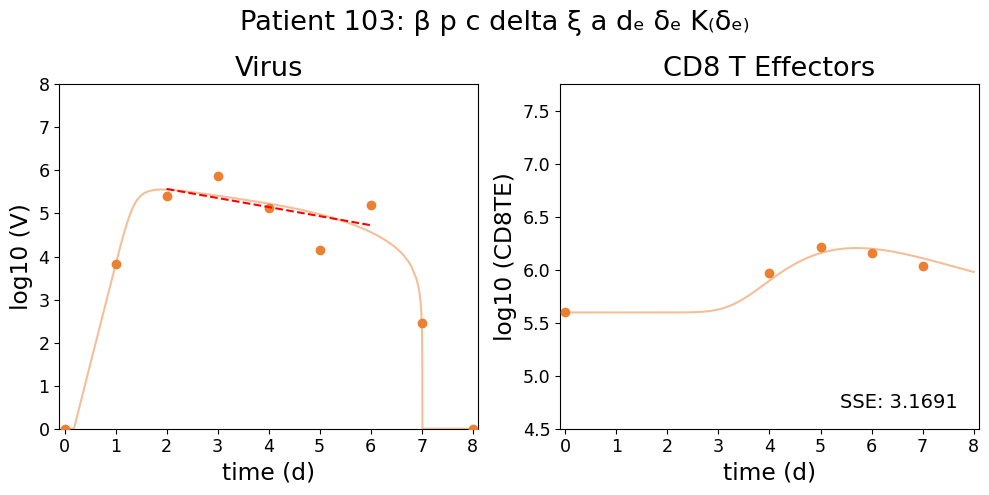

107 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.7063709235009918
differential_evolution step 2: f(x)= 1.5605960210489593
differential_evolution step 3: f(x)= 1.5605960210489593
differential_evolution step 4: f(x)= 1.1525875667997418
differential_evolution step 5: f(x)= 0.9130576593814417
differential_evolution step 6: f(x)= 0.9130576593814417
differential_evolution step 7: f(x)= 0.8109958254588183
differential_evolution step 8: f(x)= 0.8109958254588183
differential_evolution step 9: f(x)= 0.8109958254588183
differential_evolution step 10: f(x)= 0.7993905224092117
differential_evolution step 11: f(x)= 0.7993905224092117
differential_evolution step 12: f(x)= 0.7917397088556056
differential_evolution step 13: f(x)= 0.7846939634793958
differential_evolution step 14: f(x)= 0.7846939634793958
differential_evolution step 15: f(x)= 0.7846939634793958
differential_evolution step 16: f(x)= 0.7846939634793958
differential_evolution step 17: f(x

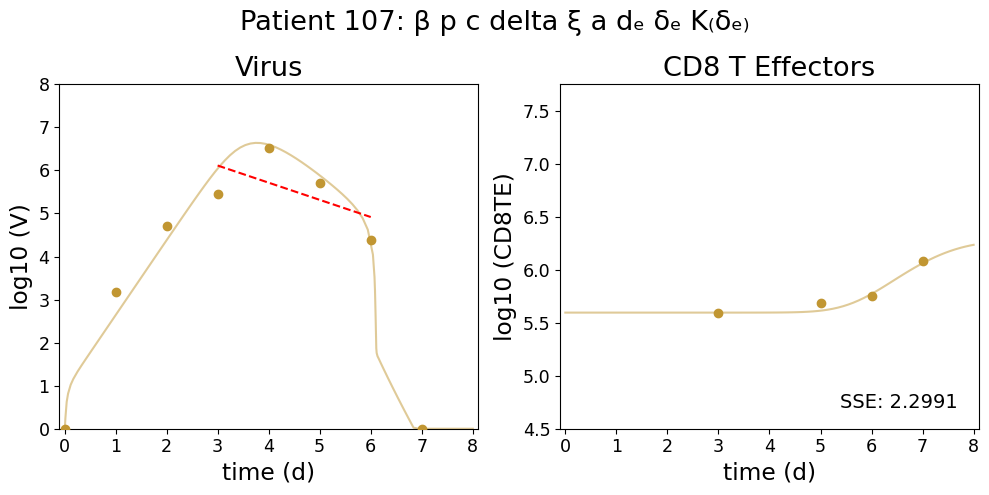

110 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 0.5797083854950544
differential_evolution step 2: f(x)= 0.3551666719629975
differential_evolution step 3: f(x)= 0.28234239413910683
differential_evolution step 4: f(x)= 0.22853833538740784
differential_evolution step 5: f(x)= 0.22853833538740784
differential_evolution step 6: f(x)= 0.22853833538740784
differential_evolution step 7: f(x)= 0.19744698438123853
differential_evolution step 8: f(x)= 0.17807972905922448
differential_evolution step 9: f(x)= 0.15812540945859938
differential_evolution step 10: f(x)= 0.1509740698721805
differential_evolution step 11: f(x)= 0.1509740698721805
differential_evolution step 12: f(x)= 0.1509740698721805
differential_evolution step 13: f(x)= 0.14405562779942027
differential_evolution step 14: f(x)= 0.13922069537936366
differential_evolution step 15: f(x)= 0.13922069537936366
differential_evolution step 16: f(x)= 0.1386633291970443
differential_evolution st

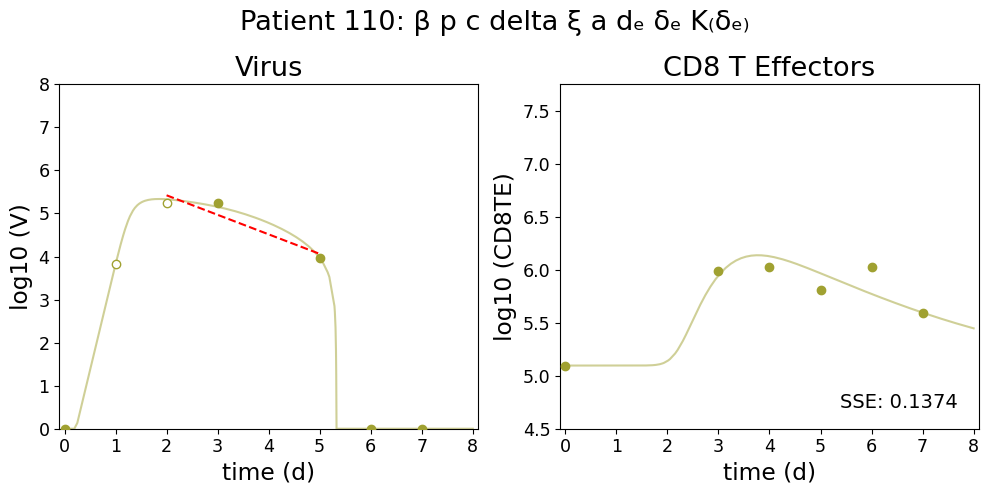

111 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 4.481378380970937
differential_evolution step 2: f(x)= 4.481378380970937
differential_evolution step 3: f(x)= 1.6833815092518727
differential_evolution step 4: f(x)= 1.544436508211678
differential_evolution step 5: f(x)= 1.4348608827760039
differential_evolution step 6: f(x)= 1.4348608827760039
differential_evolution step 7: f(x)= 1.4272082343532277
differential_evolution step 8: f(x)= 1.4272082343532277
differential_evolution step 9: f(x)= 1.4272082343532277
differential_evolution step 10: f(x)= 1.4272082343532277
differential_evolution step 11: f(x)= 1.3106455731566076
differential_evolution step 12: f(x)= 1.302292511005302
differential_evolution step 13: f(x)= 1.302292511005302
differential_evolution step 14: f(x)= 1.302292511005302
differential_evolution step 15: f(x)= 1.275980155520336
differential_evolution step 16: f(x)= 1.2720297609559577
differential_evolution step 17: f(x)= 1.27

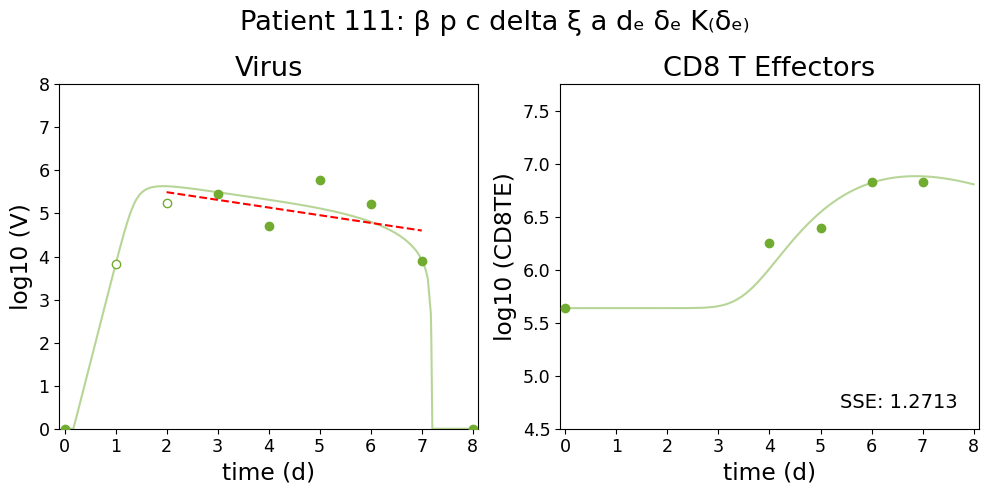

112 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.5676797943492908
differential_evolution step 2: f(x)= 1.5676797943492908
differential_evolution step 3: f(x)= 1.4657407201608246
differential_evolution step 4: f(x)= 1.2557840194226673
differential_evolution step 5: f(x)= 1.2557840194226673
differential_evolution step 6: f(x)= 1.2557840194226673
differential_evolution step 7: f(x)= 1.2557840194226673
differential_evolution step 8: f(x)= 1.2450397207087278
differential_evolution step 9: f(x)= 1.2450397207087278
differential_evolution step 10: f(x)= 1.1850474827750812
differential_evolution step 11: f(x)= 1.1822915657084836
differential_evolution step 12: f(x)= 1.1705975762470078
differential_evolution step 13: f(x)= 1.1597541917353662
differential_evolution step 14: f(x)= 1.1580064657612301
differential_evolution step 15: f(x)= 1.1552305465999708
differential_evolution step 16: f(x)= 1.1527711153781608
differential_evolution step 17: f(x

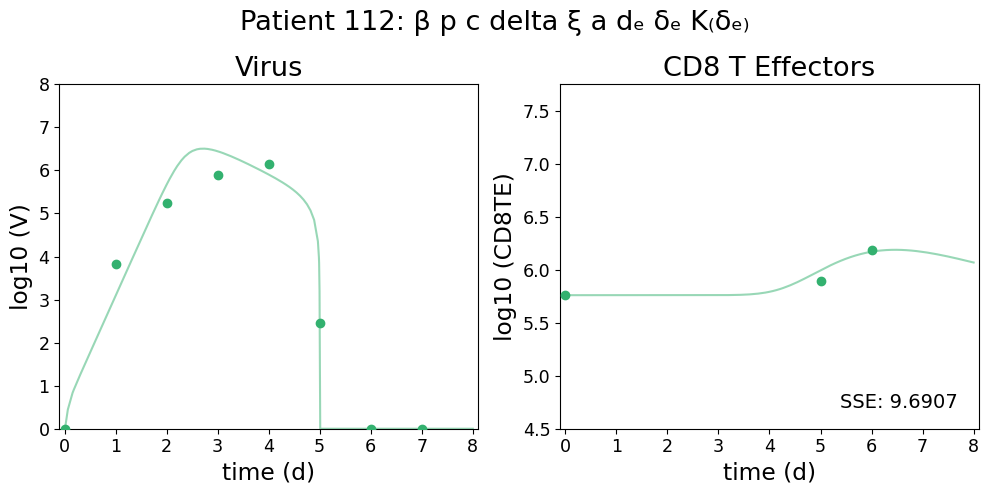

204 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 0.8961907378129699
differential_evolution step 2: f(x)= 0.571425009829143
differential_evolution step 3: f(x)= 0.49024084775612214
differential_evolution step 4: f(x)= 0.420438301778483
differential_evolution step 5: f(x)= 0.3976502186903205
differential_evolution step 6: f(x)= 0.3976502186903205
differential_evolution step 7: f(x)= 0.3959483393259667
differential_evolution step 8: f(x)= 0.3808766981407711
differential_evolution step 9: f(x)= 0.3808766981407711
differential_evolution step 10: f(x)= 0.3566263868383049
differential_evolution step 11: f(x)= 0.3566263868383049
differential_evolution step 12: f(x)= 0.35207179239034814
differential_evolution step 13: f(x)= 0.35207179239034814
differential_evolution step 14: f(x)= 0.35207179239034814
differential_evolution step 15: f(x)= 0.35110250957905664
differential_evolution step 16: f(x)= 0.35110250957905664
differential_evolution step 17:

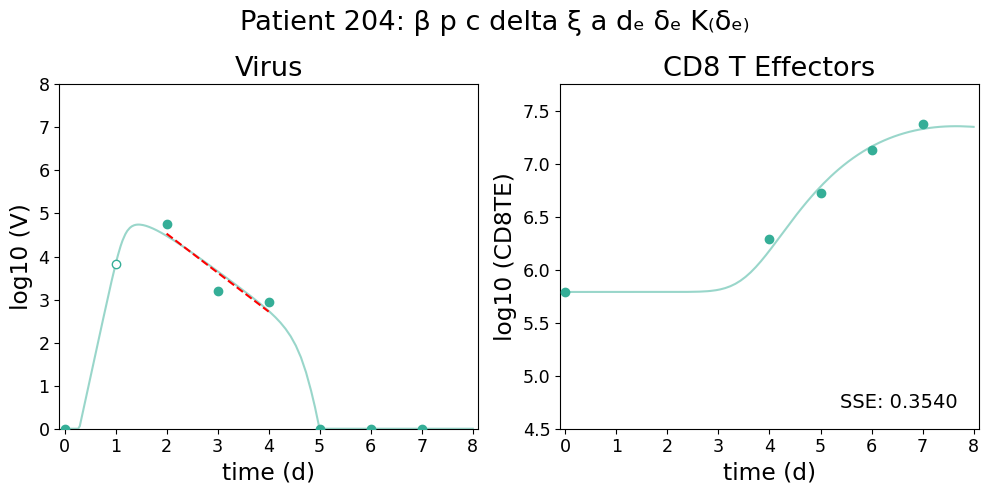

207 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.2562050489143095
differential_evolution step 2: f(x)= 2.2562050489143095
differential_evolution step 3: f(x)= 2.2562050489143095
differential_evolution step 4: f(x)= 1.5567089665447185
differential_evolution step 5: f(x)= 1.0726247188881188
differential_evolution step 6: f(x)= 1.0154903015757983
differential_evolution step 7: f(x)= 0.9821488876614455
differential_evolution step 8: f(x)= 0.5288430736642119
differential_evolution step 9: f(x)= 0.4611410388235082
differential_evolution step 10: f(x)= 0.4611410388235082
differential_evolution step 11: f(x)= 0.3998385623059198
differential_evolution step 12: f(x)= 0.3904244848599041
differential_evolution step 13: f(x)= 0.3904244848599041
differential_evolution step 14: f(x)= 0.38422965764321654
differential_evolution step 15: f(x)= 0.3767125242984191
differential_evolution step 16: f(x)= 0.3759692013128445
differential_evolution step 17: f(

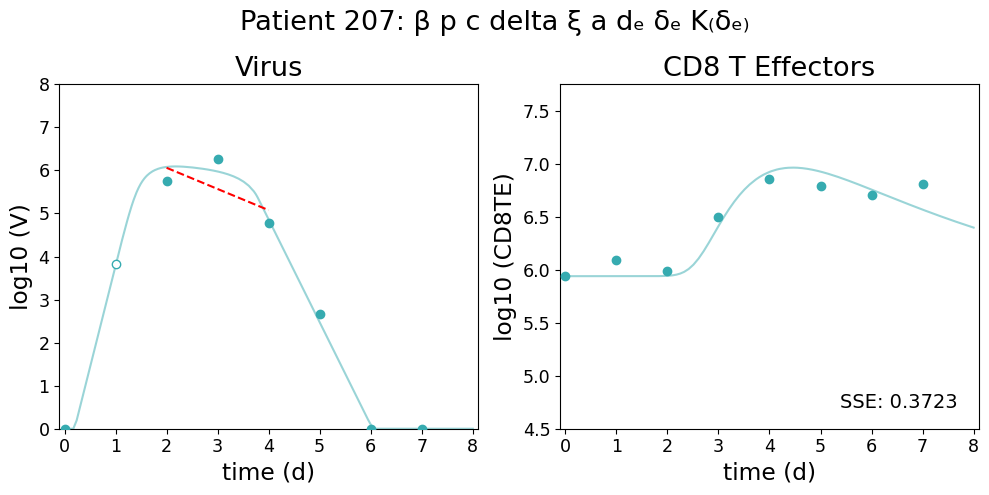

302 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.600566631297994
differential_evolution step 2: f(x)= 2.600566631297994
differential_evolution step 3: f(x)= 2.3627872914166885
differential_evolution step 4: f(x)= 2.137258772692263
differential_evolution step 5: f(x)= 2.137258772692263
differential_evolution step 6: f(x)= 1.4072776804612208
differential_evolution step 7: f(x)= 1.1539971214538478
differential_evolution step 8: f(x)= 1.1539971214538478
differential_evolution step 9: f(x)= 0.824432755727862
differential_evolution step 10: f(x)= 0.7256598106709661
differential_evolution step 11: f(x)= 0.7256598106709661
differential_evolution step 12: f(x)= 0.7256598106709661
differential_evolution step 13: f(x)= 0.6530436607432524
differential_evolution step 14: f(x)= 0.6530436607432524
differential_evolution step 15: f(x)= 0.6530436607432524
differential_evolution step 16: f(x)= 0.6244884519250061
differential_evolution step 17: f(x)= 0.

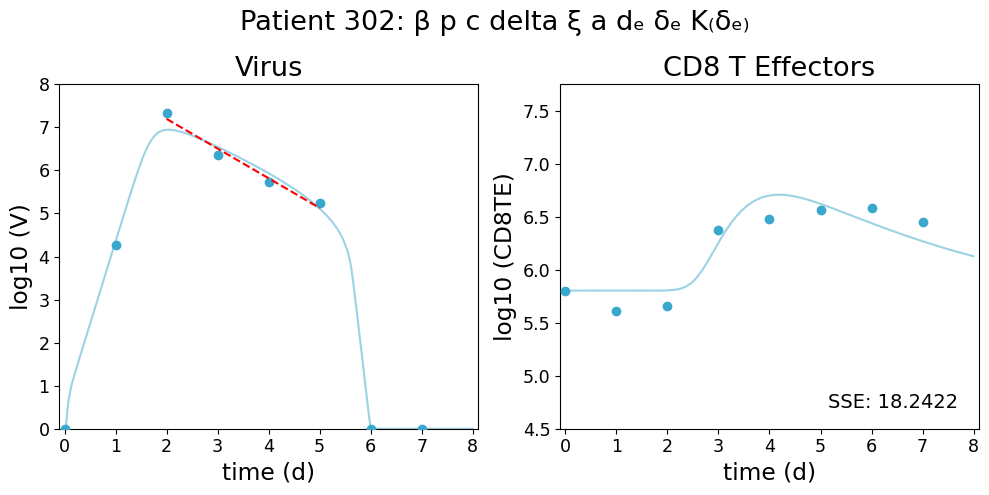

307 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.9191449569355727
differential_evolution step 2: f(x)= 1.9191449569355727
differential_evolution step 3: f(x)= 1.9191449569355727
differential_evolution step 4: f(x)= 1.9191449569355727
differential_evolution step 5: f(x)= 1.2718800805352068
differential_evolution step 6: f(x)= 1.2718800805352068
differential_evolution step 7: f(x)= 1.1407954699484162
differential_evolution step 8: f(x)= 0.9619200310770288
differential_evolution step 9: f(x)= 0.959438208870311
differential_evolution step 10: f(x)= 0.959438208870311
differential_evolution step 11: f(x)= 0.8561560373494502
differential_evolution step 12: f(x)= 0.8206915112764789
differential_evolution step 13: f(x)= 0.8206915112764789
differential_evolution step 14: f(x)= 0.7961262498332393
differential_evolution step 15: f(x)= 0.7079810538615547
differential_evolution step 16: f(x)= 0.6697815168649133
differential_evolution step 17: f(x)=

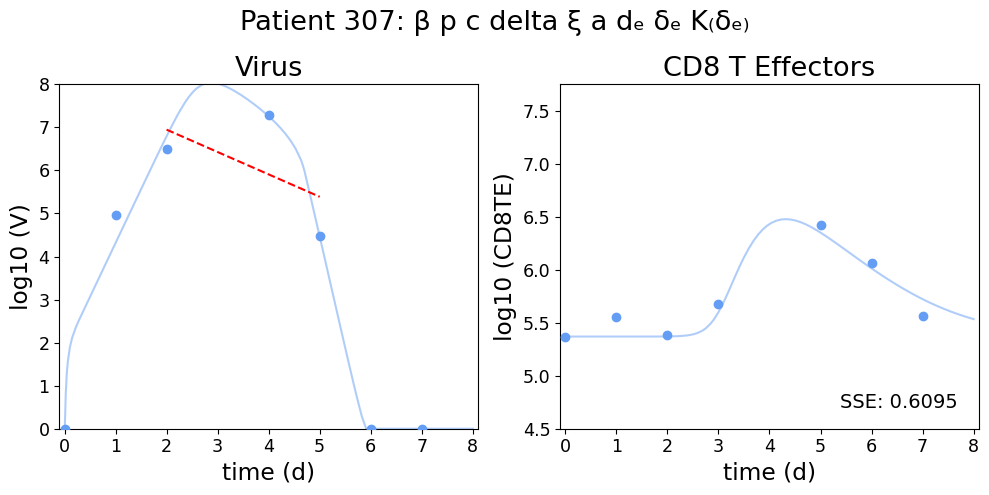

308 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 4.3095186596429
differential_evolution step 2: f(x)= 4.3095186596429
differential_evolution step 3: f(x)= 2.8733712764905954
differential_evolution step 4: f(x)= 2.1033885469473454
differential_evolution step 5: f(x)= 1.9894192072221064
differential_evolution step 6: f(x)= 1.9423863165774071
differential_evolution step 7: f(x)= 1.9423863165774071
differential_evolution step 8: f(x)= 1.923218758983664
differential_evolution step 9: f(x)= 1.923218758983664
differential_evolution step 10: f(x)= 1.9223940884755926
differential_evolution step 11: f(x)= 1.9172664280610108
differential_evolution step 12: f(x)= 1.9082577089919335
differential_evolution step 13: f(x)= 1.9082577089919335
differential_evolution step 14: f(x)= 1.9073716637091767
differential_evolution step 15: f(x)= 1.9073716637091767
differential_evolution step 16: f(x)= 1.9069032408489648
differential_evolution step 17: f(x)= 1.906

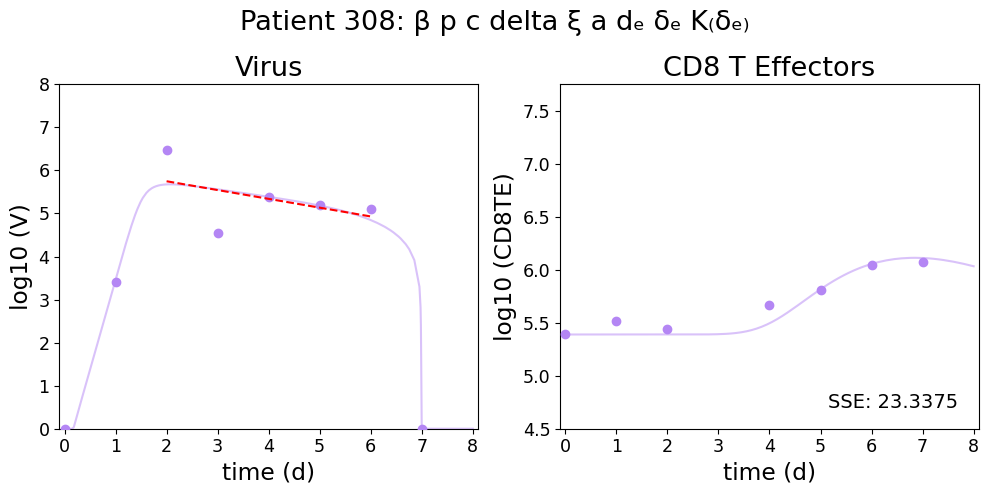

311 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.3104544560703242
differential_evolution step 2: f(x)= 1.3104544560703242
differential_evolution step 3: f(x)= 0.6040382045048556
differential_evolution step 4: f(x)= 0.6040382045048556
differential_evolution step 5: f(x)= 0.5209470510158677
differential_evolution step 6: f(x)= 0.46266457498063024
differential_evolution step 7: f(x)= 0.4287468557946728
differential_evolution step 8: f(x)= 0.4287468557946728
differential_evolution step 9: f(x)= 0.425684822381338
differential_evolution step 10: f(x)= 0.425684822381338
differential_evolution step 11: f(x)= 0.41712981007121136
differential_evolution step 12: f(x)= 0.41712981007121136
differential_evolution step 13: f(x)= 0.41712981007121136
differential_evolution step 14: f(x)= 0.41712981007121136
differential_evolution step 15: f(x)= 0.41712981007121136
differential_evolution step 16: f(x)= 0.41712981007121136
differential_evolution step 17

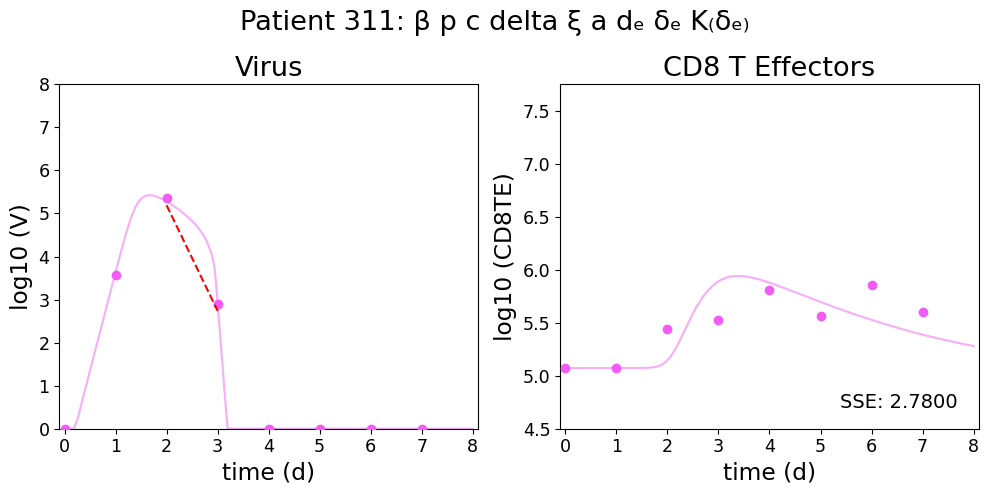

312 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 4.521316751197841
differential_evolution step 2: f(x)= 3.6691290756717607
differential_evolution step 3: f(x)= 3.5779680087704078
differential_evolution step 4: f(x)= 3.552107624361076
differential_evolution step 5: f(x)= 3.5479662482749363
differential_evolution step 6: f(x)= 3.535956765515321
differential_evolution step 7: f(x)= 3.5305704700153657
differential_evolution step 8: f(x)= 3.5184807710586194
differential_evolution step 9: f(x)= 3.5184807710586194
differential_evolution step 10: f(x)= 3.5184807710586194
differential_evolution step 11: f(x)= 3.518391316651945
differential_evolution step 12: f(x)= 3.5062077841207286
differential_evolution step 13: f(x)= 3.5062077841207286
differential_evolution step 14: f(x)= 3.506125088042533
differential_evolution step 15: f(x)= 3.5060813640546873
differential_evolution step 16: f(x)= 3.5060813640546873
Results saved to sql/LCT_Viral_Fullest.d

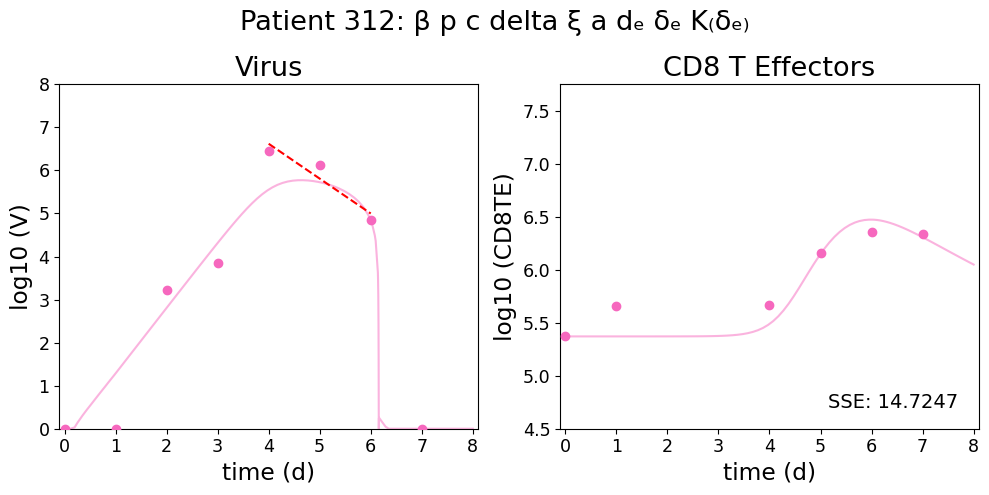

In [8]:
# LCT Model, Viral Parameters (p + 8 others)
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=1.1E5, u_lim=8.9E5, method='file', space='log10'), 
    T0=Parameter(name='T0', val=4E7, l_lim=1E4, u_lim=4E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-7, u_lim=1E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=0.02978, l_lim=5E-2, u_lim=1E3, method='fit', space='log10'), 
    c=Parameter(name='c', val=13.934, l_lim=5.0, u_lim=5E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=1E2, method='fit', space='log10'), 
    a=Parameter(name='a', val=2.5, l_lim=1.0, u_lim=10, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.55, u_lim=1.0, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in ids:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=10000, verbose=True, path='Viral_Full')

    plot(results, subplot_configuration, title=None, group=False, save=False)

103 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 5.263287461291215
differential_evolution step 2: f(x)= 2.3129067581658735
differential_evolution step 3: f(x)= 1.5520004641097276
differential_evolution step 4: f(x)= 1.5520004641097276
differential_evolution step 5: f(x)= 1.4866627766571945
differential_evolution step 6: f(x)= 1.4866627766571945
differential_evolution step 7: f(x)= 1.4866627766571945
differential_evolution step 8: f(x)= 1.4751800566089608
differential_evolution step 9: f(x)= 1.4731317809256508
differential_evolution step 10: f(x)= 1.472401068760095
differential_evolution step 11: f(x)= 1.4717064721849409
differential_evolution step 12: f(x)= 1.4717064721849409
differential_evolution step 13: f(x)= 1.471604772612124
differential_evolution step 14: f(x)= 1.4715933673098036
Results saved to sql/LCT_Viral_Reduced.db.
Parameter beta: 8.373097560131778e-05
Parameter p: 4.3029429632400555
Parameter c: 346.8980109278943
Paramete

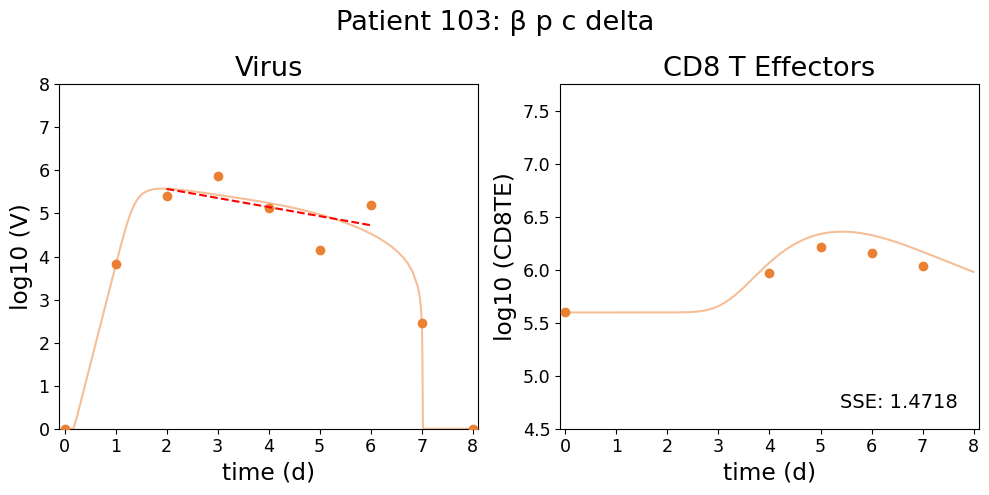

107 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.028090540446472
differential_evolution step 2: f(x)= 1.028090540446472
differential_evolution step 3: f(x)= 1.028090540446472
differential_evolution step 4: f(x)= 1.028090540446472
differential_evolution step 5: f(x)= 1.028090540446472
differential_evolution step 6: f(x)= 0.9527269333170784
differential_evolution step 7: f(x)= 0.9345866928079103
differential_evolution step 8: f(x)= 0.9345866928079103
differential_evolution step 9: f(x)= 0.9345866928079103
differential_evolution step 10: f(x)= 0.9251542594039557
differential_evolution step 11: f(x)= 0.9251542594039557
differential_evolution step 12: f(x)= 0.921431615088411
differential_evolution step 13: f(x)= 0.921431615088411
differential_evolution step 14: f(x)= 0.921431615088411
differential_evolution step 15: f(x)= 0.921431615088411
differential_evolution step 16: f(x)= 0.921431615088411
differential_evolution step 17: f(x)= 0.92143

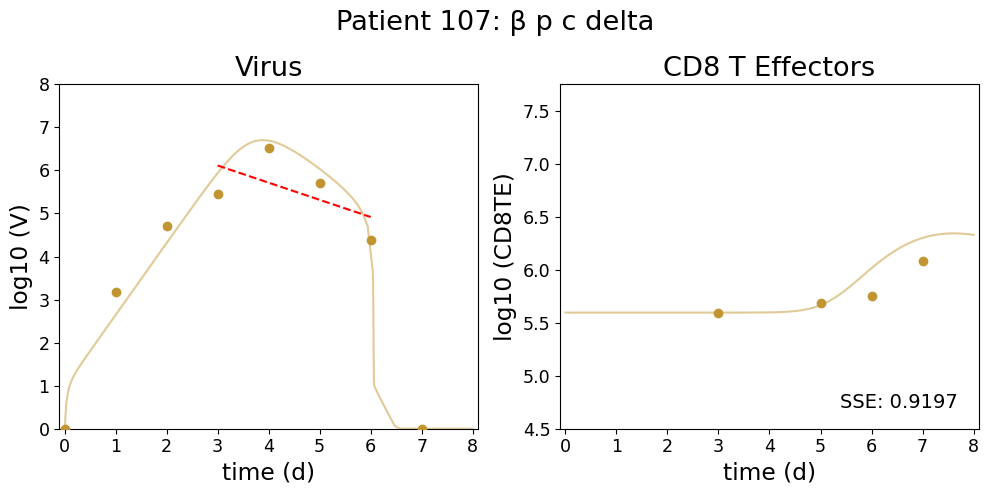

110 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.1975600135115905
differential_evolution step 2: f(x)= 1.1975600135115905
differential_evolution step 3: f(x)= 1.1975600135115905
differential_evolution step 4: f(x)= 1.1975600135115905
differential_evolution step 5: f(x)= 1.0065442262014093
differential_evolution step 6: f(x)= 1.0065442262014093
differential_evolution step 7: f(x)= 0.9601017774282141
differential_evolution step 8: f(x)= 0.9601017774282141
differential_evolution step 9: f(x)= 0.9501416192111865
differential_evolution step 10: f(x)= 0.9501416192111865
differential_evolution step 11: f(x)= 0.9489236872388734
differential_evolution step 12: f(x)= 0.9481153645048804
differential_evolution step 13: f(x)= 0.9480053841514341
differential_evolution step 14: f(x)= 0.9477983951742203
differential_evolution step 15: f(x)= 0.9477983951742203
Results saved to sql/LCT_Viral_Reduced.db.
Parameter beta: 0.00035825458076375996
Parameter 

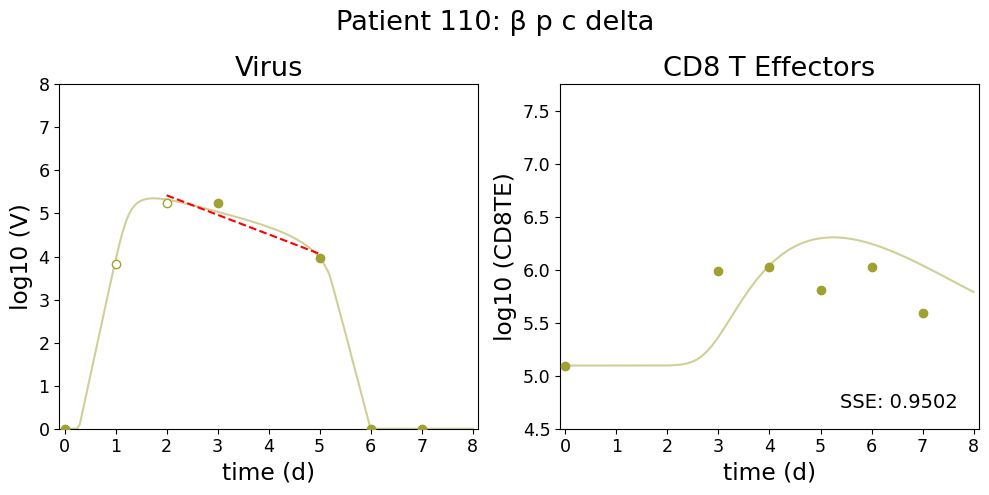

111 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 6.841197546179871
differential_evolution step 2: f(x)= 5.8236708293145805
differential_evolution step 3: f(x)= 4.906506854724108
differential_evolution step 4: f(x)= 3.42726353769268
differential_evolution step 5: f(x)= 2.3164172531458345
differential_evolution step 6: f(x)= 2.3164172531458345
differential_evolution step 7: f(x)= 2.170412845701844
differential_evolution step 8: f(x)= 2.170412845701844
differential_evolution step 9: f(x)= 2.170412845701844
differential_evolution step 10: f(x)= 2.170412845701844
differential_evolution step 11: f(x)= 2.170412845701844
differential_evolution step 12: f(x)= 2.170412845701844
differential_evolution step 13: f(x)= 2.142930854849799
differential_evolution step 14: f(x)= 2.142930854849799
differential_evolution step 15: f(x)= 2.138838491337746
differential_evolution step 16: f(x)= 2.138838491337746
differential_evolution step 17: f(x)= 2.138838491

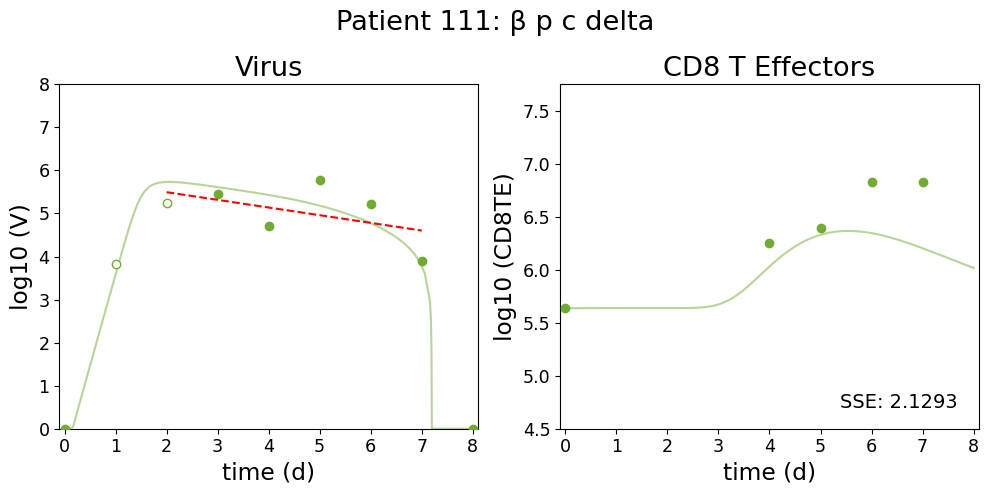

112 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.2601419847176576
differential_evolution step 2: f(x)= 1.9866896312744338
differential_evolution step 3: f(x)= 1.9866896312744338
differential_evolution step 4: f(x)= 1.8861394719551878
differential_evolution step 5: f(x)= 1.8861394719551878
differential_evolution step 6: f(x)= 1.8861394719551878
differential_evolution step 7: f(x)= 1.8604590875145044
differential_evolution step 8: f(x)= 1.8479415840678772
differential_evolution step 9: f(x)= 1.822830914614878
differential_evolution step 10: f(x)= 1.8114900040711313
differential_evolution step 11: f(x)= 1.8114900040711313
differential_evolution step 12: f(x)= 1.7986229341670772
differential_evolution step 13: f(x)= 1.786547816263296
differential_evolution step 14: f(x)= 1.786547816263296
differential_evolution step 15: f(x)= 1.786547816263296
differential_evolution step 16: f(x)= 1.7865226395183103
differential_evolution step 17: f(x)= 1

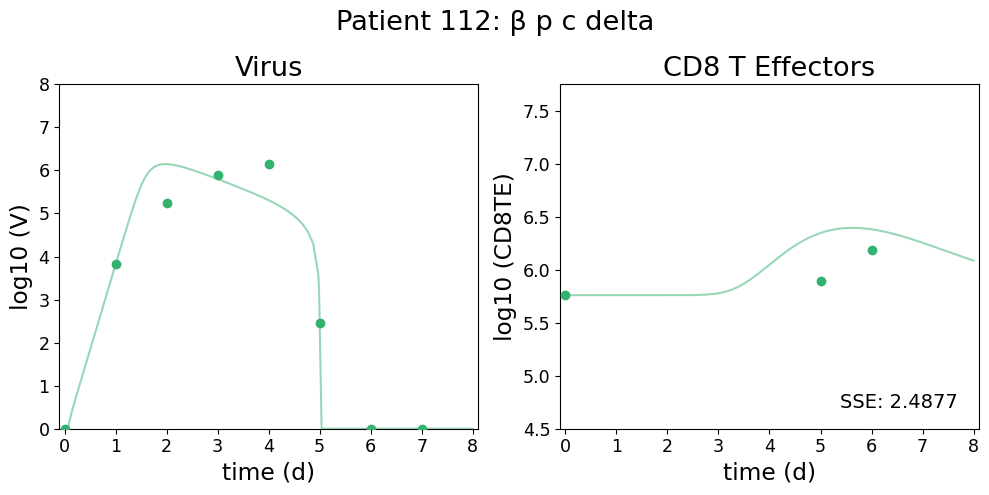

204 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 3.0204390609501575
differential_evolution step 2: f(x)= 2.733253356774377
differential_evolution step 3: f(x)= 2.6425163558003346
differential_evolution step 4: f(x)= 2.638682704811629
differential_evolution step 5: f(x)= 2.638682704811629
differential_evolution step 6: f(x)= 2.6292671159332794
differential_evolution step 7: f(x)= 2.6235227979695717
differential_evolution step 8: f(x)= 2.622220103009715
differential_evolution step 9: f(x)= 2.6215915258217577
differential_evolution step 10: f(x)= 2.621536170742285
differential_evolution step 11: f(x)= 2.6215294536997575
Results saved to sql/LCT_Viral_Reduced.db.
Parameter beta: 0.0009395152584305443
Parameter p: 7.457187731631405
Parameter c: 4662.0822320680045
Parameter delta: 1.4163200848204216


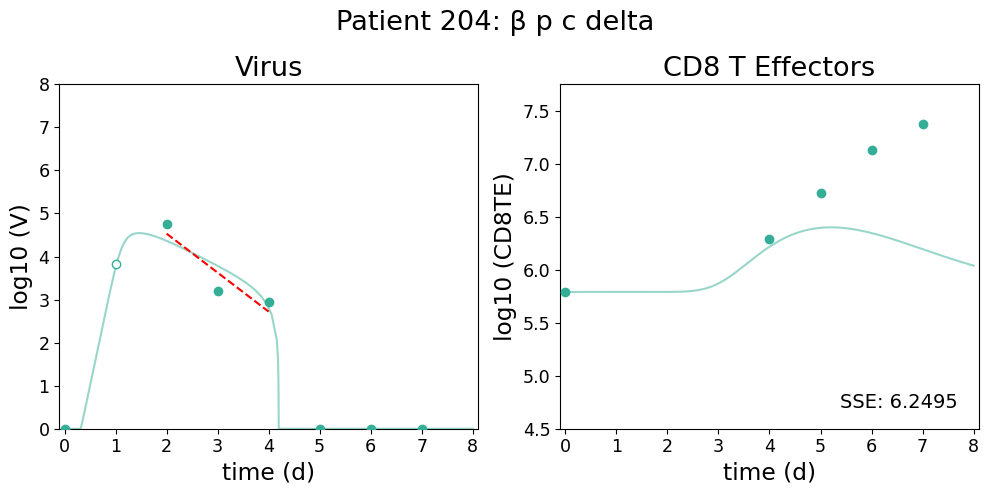

207 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.794427706365925
differential_evolution step 2: f(x)= 1.884945300663633
differential_evolution step 3: f(x)= 1.7958947664961287
differential_evolution step 4: f(x)= 1.7958947664961287
differential_evolution step 5: f(x)= 1.7958947664961287
differential_evolution step 6: f(x)= 1.7796131752227018
differential_evolution step 7: f(x)= 1.7791459525098983
differential_evolution step 8: f(x)= 1.777099895501507
differential_evolution step 9: f(x)= 1.777099895501507
differential_evolution step 10: f(x)= 1.777099895501507
differential_evolution step 11: f(x)= 1.777099895501507
Results saved to sql/LCT_Viral_Reduced.db.
Parameter beta: 3.845768951770591e-05
Parameter p: 0.44549106139640193
Parameter c: 6.155724253246698
Parameter delta: 1.542545805185779


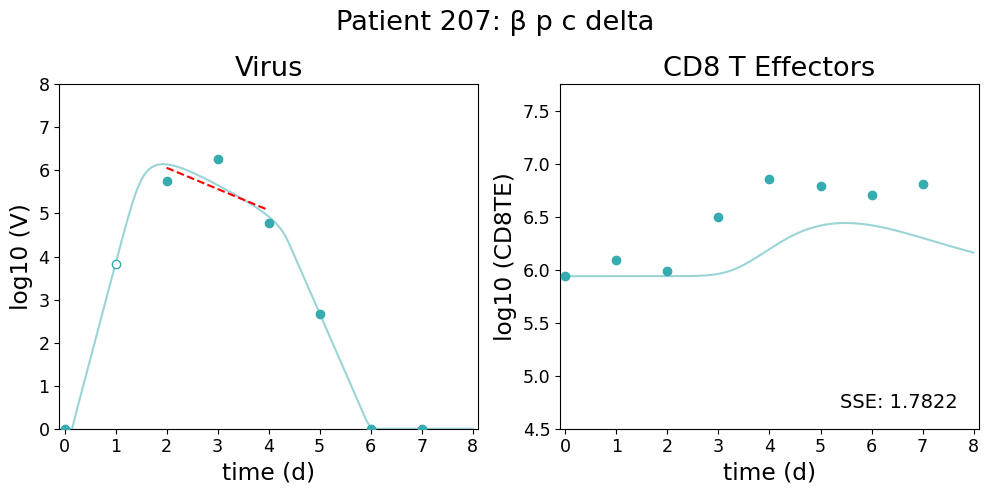

302 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.2270063542856309
differential_evolution step 2: f(x)= 1.2091633481470634
differential_evolution step 3: f(x)= 1.200332661569154
differential_evolution step 4: f(x)= 1.200332661569154
differential_evolution step 5: f(x)= 1.200332661569154
differential_evolution step 6: f(x)= 1.1978406929728633
differential_evolution step 7: f(x)= 1.1969036246111293
differential_evolution step 8: f(x)= 1.194650323221586
differential_evolution step 9: f(x)= 1.194650323221586
differential_evolution step 10: f(x)= 1.1945548942838347
differential_evolution step 11: f(x)= 1.1945548942838347
Results saved to sql/LCT_Viral_Reduced.db.
Parameter beta: 3.0125832518381057e-06
Parameter p: 216.63915675458614
Parameter c: 829.1338070821112
Parameter delta: 0.9755653912659563


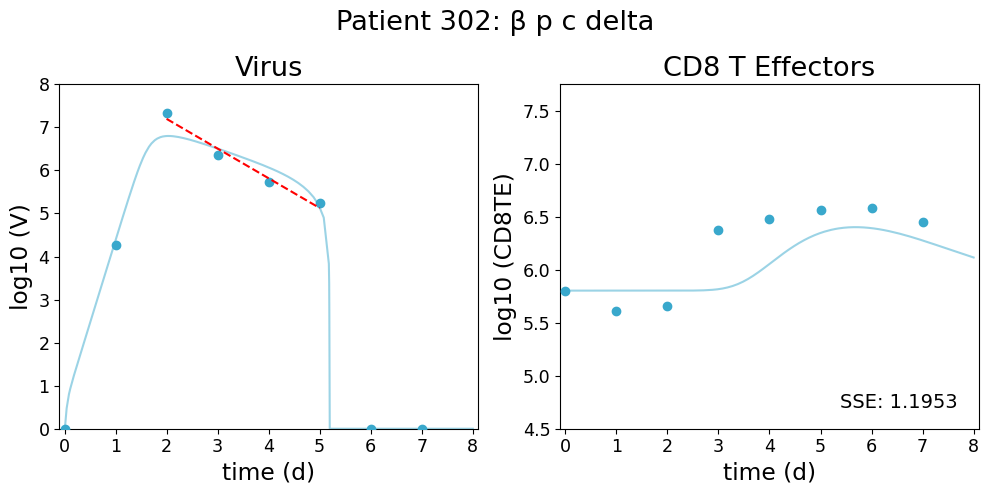

307 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.8112168566351037
differential_evolution step 2: f(x)= 1.8112168566351037
differential_evolution step 3: f(x)= 1.8112168566351037
differential_evolution step 4: f(x)= 1.8112168566351037
differential_evolution step 5: f(x)= 1.8112168566351037
differential_evolution step 6: f(x)= 1.4638774187187833
differential_evolution step 7: f(x)= 1.4638774187187833
differential_evolution step 8: f(x)= 1.4638774187187833
differential_evolution step 9: f(x)= 1.4638774187187833
differential_evolution step 10: f(x)= 1.4638774187187833
differential_evolution step 11: f(x)= 1.4638774187187833
differential_evolution step 12: f(x)= 1.4638774187187833
differential_evolution step 13: f(x)= 1.4638774187187833
differential_evolution step 14: f(x)= 1.4562430742554313
differential_evolution step 15: f(x)= 1.4431050539462336
differential_evolution step 16: f(x)= 1.4380656617116436
differential_evolution step 17: f(x

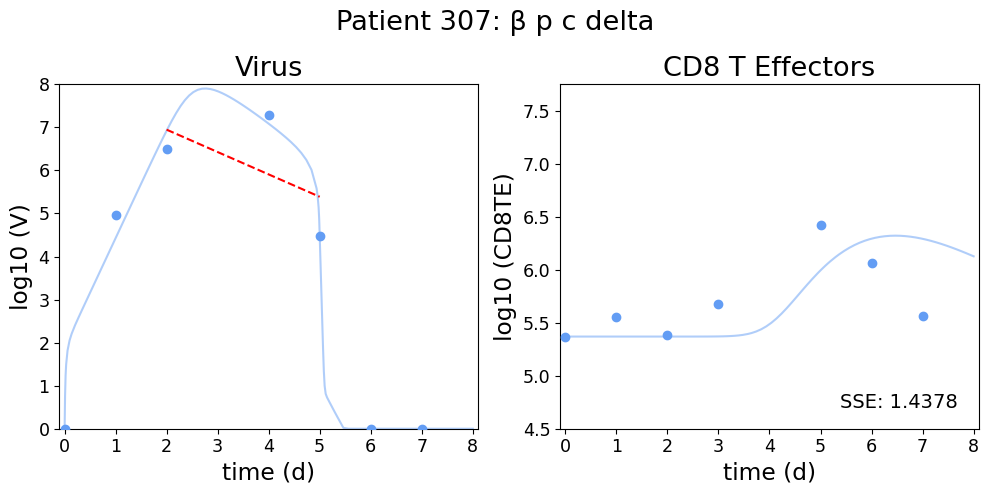

308 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.6217756011377036
differential_evolution step 2: f(x)= 2.6217756011377036
differential_evolution step 3: f(x)= 2.425458768387973
differential_evolution step 4: f(x)= 2.3733924843122973
differential_evolution step 5: f(x)= 2.3593816212421364
differential_evolution step 6: f(x)= 2.3593816212421364
differential_evolution step 7: f(x)= 2.358906630252332
differential_evolution step 8: f(x)= 2.358906630252332
differential_evolution step 9: f(x)= 2.3581890864615644
differential_evolution step 10: f(x)= 2.3540196517466616
differential_evolution step 11: f(x)= 2.3521816798665065
differential_evolution step 12: f(x)= 2.3486462775098684
differential_evolution step 13: f(x)= 2.346735961858765
differential_evolution step 14: f(x)= 2.3462737119276302
differential_evolution step 15: f(x)= 2.3460702074501643
Results saved to sql/LCT_Viral_Reduced.db.
Parameter beta: 4.362601947216982e-05
Parameter p: 10

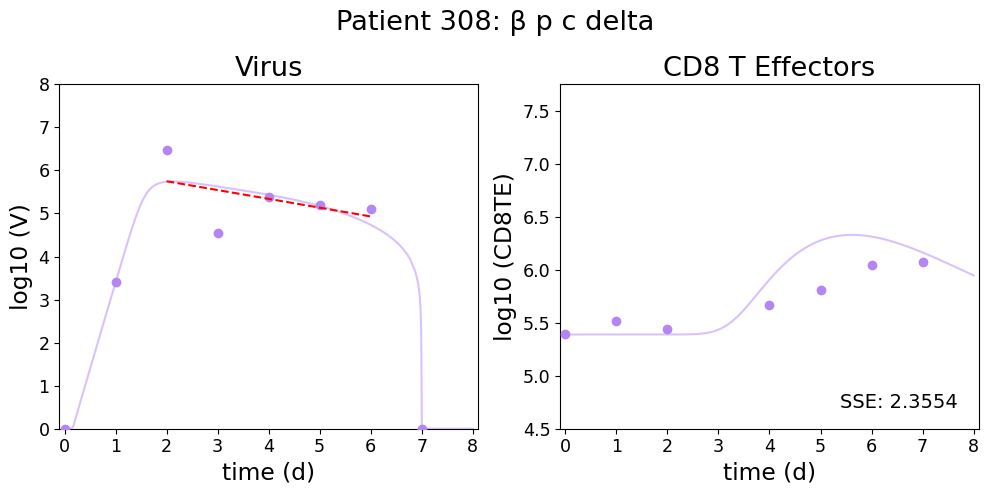

311 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.4795977067712585
differential_evolution step 2: f(x)= 2.2982697315236096
differential_evolution step 3: f(x)= 2.22629469097249
differential_evolution step 4: f(x)= 2.221656613608374
differential_evolution step 5: f(x)= 2.219551888783251
differential_evolution step 6: f(x)= 2.219551888783251
differential_evolution step 7: f(x)= 2.218491105439888
differential_evolution step 8: f(x)= 2.218491105439888
differential_evolution step 9: f(x)= 2.218491105439888
differential_evolution step 10: f(x)= 2.217115634641397
differential_evolution step 11: f(x)= 2.216391822258891
differential_evolution step 12: f(x)= 2.216391822258891
Results saved to sql/LCT_Viral_Reduced.db.
Parameter beta: 0.0003232256429931594
Parameter p: 14.945474108384078
Parameter c: 3558.3222134457264
Parameter delta: 2.499220618178291


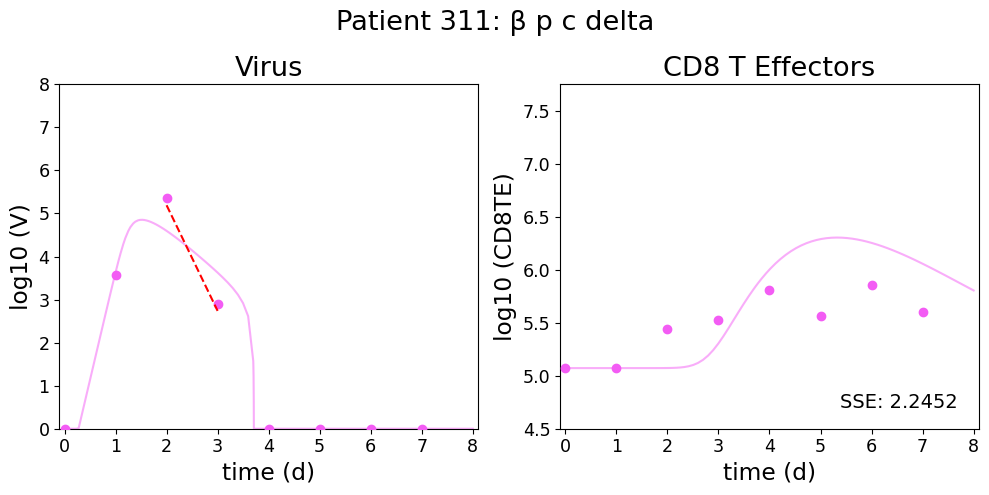

312 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 5.740061362514933
differential_evolution step 2: f(x)= 5.289003157923155
differential_evolution step 3: f(x)= 5.129483035566983
differential_evolution step 4: f(x)= 4.949141999812382
differential_evolution step 5: f(x)= 4.859451552655278
differential_evolution step 6: f(x)= 4.859451552655278
differential_evolution step 7: f(x)= 4.859451552655278
differential_evolution step 8: f(x)= 4.859451552655278
differential_evolution step 9: f(x)= 4.803657242053425
differential_evolution step 10: f(x)= 4.803657242053425
differential_evolution step 11: f(x)= 4.803657242053425
differential_evolution step 12: f(x)= 4.8035071396749665
differential_evolution step 13: f(x)= 4.8035071396749665
differential_evolution step 14: f(x)= 4.800098868619875
Results saved to sql/LCT_Viral_Reduced.db.
Parameter beta: 9.167648706240842e-06
Parameter p: 1.2227682839763703
Parameter c: 42.96464000475442
Parameter delta: 

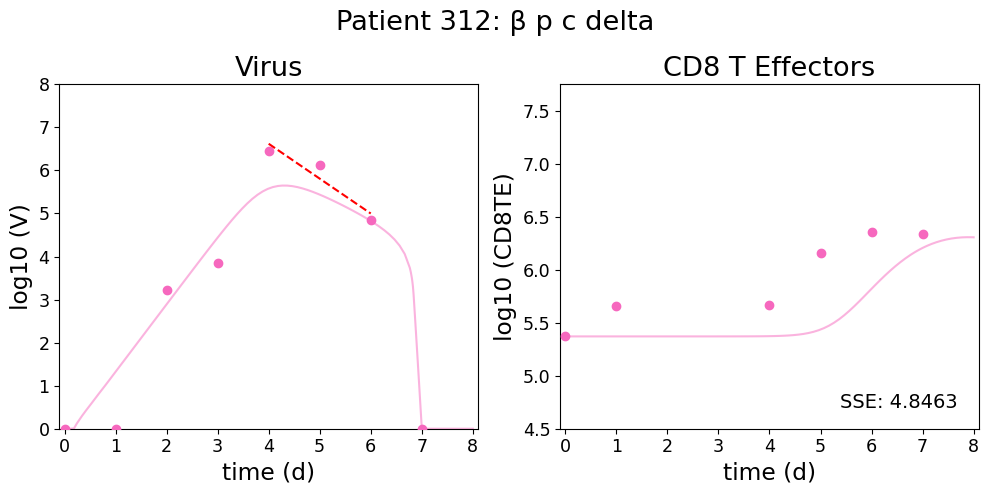

: 

In [6]:
# LCT Model, fixed Population T cell parameters, fit p, beta, c, delta (mmatch Reduced Viral Model in DOF)
# Can Viral parameters but fixed (population) T cell parameters recapture both virus and T cell dynamcs? (Is T cell hetergeoneity necessary)
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=1.1E5, u_lim=8.9E5, method='file', space='log10'), 
    T0=Parameter(name='T0', val=4E7, l_lim=1E4, u_lim=4E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-7, u_lim=1E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=0.02978, l_lim=5E-2, u_lim=1E3, method='fit', space='log10'), 
    c=Parameter(name='c', val=13.934, l_lim=5.0, u_lim=5E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.497465, l_lim=1E-2, u_lim=1E2, method='fixed', space='log10'), 
    a=Parameter(name='a', val=3.943744, l_lim=1.0, u_lim=10, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=0.767826, l_lim=0.5, u_lim=1.0, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=1.572749, l_lim=1E-1, u_lim=10, method='fixed', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=442.268564, l_lim=1E1, u_lim=1E6, method='fixed', space='log10'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=10000, verbose=True, path='Viral_Reduced')

    plot(results, subplot_configuration, title=None, group=False, save=False)

Population Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 262.6162684143604
differential_evolution step 2: f(x)= 260.4621718675568
differential_evolution step 3: f(x)= 259.414376225982
differential_evolution step 4: f(x)= 257.9346679254007
differential_evolution step 5: f(x)= 255.67732534649218
differential_evolution step 6: f(x)= 253.97521629238048
differential_evolution step 7: f(x)= 241.0166561484479
differential_evolution step 8: f(x)= 238.16973024075367
differential_evolution step 9: f(x)= 238.16973024075367
differential_evolution step 10: f(x)= 238.16973024075367
differential_evolution step 11: f(x)= 238.1114634573089
differential_evolution step 12: f(x)= 238.1114634573089
differential_evolution step 13: f(x)= 238.06811796908192
differential_evolution step 14: f(x)= 237.85680098855565
differential_evolution step 15: f(x)= 237.85680098855565
differential_evolution step 16: f(x)= 237.85680098855565
differential_evolution step 17: f(x)

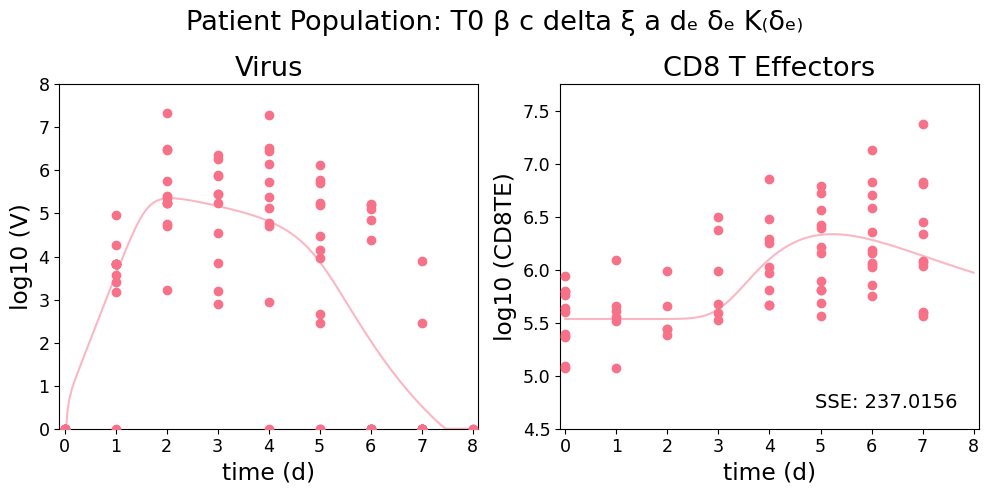

103 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.331885352685556
differential_evolution step 2: f(x)= 2.331885352685556
differential_evolution step 3: f(x)= 2.204110669753441
differential_evolution step 4: f(x)= 2.204110669753441
differential_evolution step 5: f(x)= 2.1809029309431986
differential_evolution step 6: f(x)= 2.134825302295617
differential_evolution step 7: f(x)= 1.8480284821666348
differential_evolution step 8: f(x)= 1.8480284821666348
differential_evolution step 9: f(x)= 1.7870446249343668
differential_evolution step 10: f(x)= 1.7677530146457796
differential_evolution step 11: f(x)= 1.7677530146457796
differential_evolution step 12: f(x)= 1.7677530146457796
differential_evolution step 13: f(x)= 1.7644976886652364
differential_evolution step 14: f(x)= 1.6793521216175797
differential_evolution step 15: f(x)= 1.66617981450222
differential_evolution step 16: f(x)= 1.6597442885033107
differential_evolution step 17: f(x)= 1.65

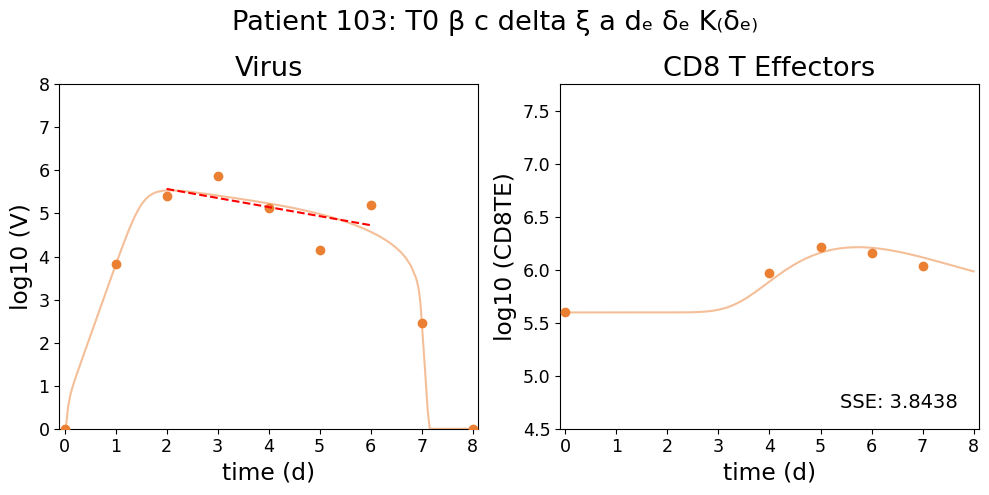

107 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 0.7613238222188321
differential_evolution step 2: f(x)= 0.7613238222188321
differential_evolution step 3: f(x)= 0.7613238222188321
differential_evolution step 4: f(x)= 0.7613238222188321
differential_evolution step 5: f(x)= 0.5653251244557178
differential_evolution step 6: f(x)= 0.5605284791615865
differential_evolution step 7: f(x)= 0.5578737389770628
differential_evolution step 8: f(x)= 0.5291710899181074
differential_evolution step 9: f(x)= 0.5173127422509708
differential_evolution step 10: f(x)= 0.514075457266845
differential_evolution step 11: f(x)= 0.514075457266845
differential_evolution step 12: f(x)= 0.5124924580129644
differential_evolution step 13: f(x)= 0.5124924580129644
differential_evolution step 14: f(x)= 0.5097024589952355
differential_evolution step 15: f(x)= 0.5097024589952355
differential_evolution step 16: f(x)= 0.5095335384458497
differential_evolution step 17: f(x)=

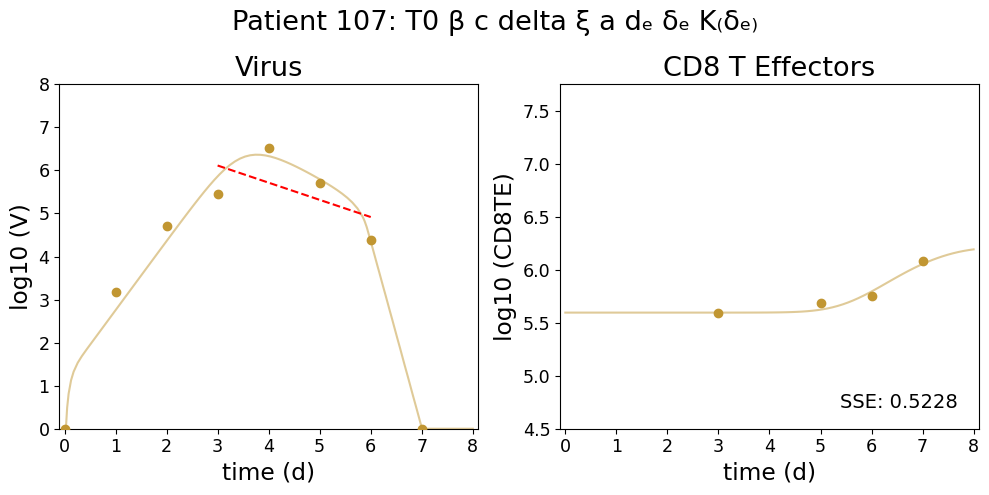

110 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.522834286483246
differential_evolution step 2: f(x)= 2.191460583072037
differential_evolution step 3: f(x)= 1.8226696031480532
differential_evolution step 4: f(x)= 0.2723782807493549
differential_evolution step 5: f(x)= 0.2723782807493549
differential_evolution step 6: f(x)= 0.2723782807493549
differential_evolution step 7: f(x)= 0.2723782807493549
differential_evolution step 8: f(x)= 0.2723782807493549
differential_evolution step 9: f(x)= 0.2723782807493549
differential_evolution step 10: f(x)= 0.1948993725438342
differential_evolution step 11: f(x)= 0.1948993725438342
differential_evolution step 12: f(x)= 0.15840499162217686
differential_evolution step 13: f(x)= 0.15840499162217686
differential_evolution step 14: f(x)= 0.15110598035544698
differential_evolution step 15: f(x)= 0.15110598035544698
differential_evolution step 16: f(x)= 0.14150008412040121
differential_evolution step 17: 

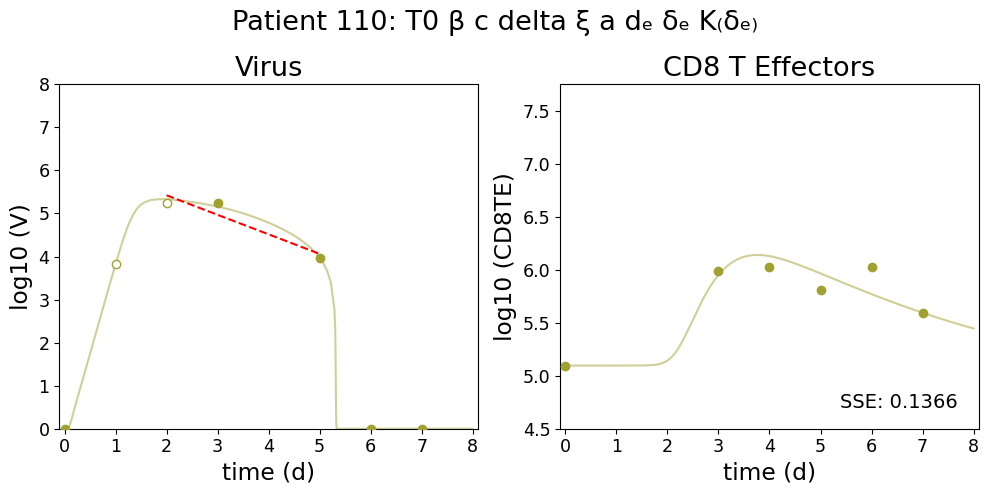

111 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 5.581095495170509
differential_evolution step 2: f(x)= 4.805596032370735
differential_evolution step 3: f(x)= 4.805596032370735
differential_evolution step 4: f(x)= 4.805596032370735
differential_evolution step 5: f(x)= 4.805596032370735
differential_evolution step 6: f(x)= 4.788291433135885
differential_evolution step 7: f(x)= 4.764696410979997
differential_evolution step 8: f(x)= 4.764696410979997
differential_evolution step 9: f(x)= 4.7565980511703705
differential_evolution step 10: f(x)= 4.7565980511703705
differential_evolution step 11: f(x)= 4.708869992335259
differential_evolution step 12: f(x)= 2.7322108820137654
differential_evolution step 13: f(x)= 1.3717604401690109
differential_evolution step 14: f(x)= 1.3465517297336018
differential_evolution step 15: f(x)= 1.292127166985155
differential_evolution step 16: f(x)= 1.292127166985155
differential_evolution step 17: f(x)= 1.280046

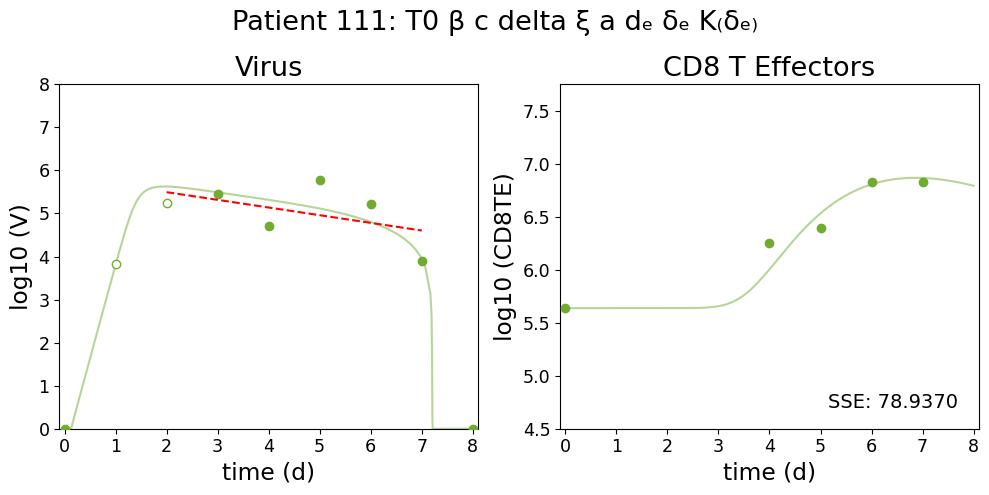

112 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.0311388247960722
differential_evolution step 2: f(x)= 1.0311388247960722
differential_evolution step 3: f(x)= 0.5889671790699498
differential_evolution step 4: f(x)= 0.5889671790699498
differential_evolution step 5: f(x)= 0.5889671790699498
differential_evolution step 6: f(x)= 0.5622988248281285
differential_evolution step 7: f(x)= 0.5129887323542904
differential_evolution step 8: f(x)= 0.5129887323542904
differential_evolution step 9: f(x)= 0.49797613078407477
differential_evolution step 10: f(x)= 0.49797613078407477
differential_evolution step 11: f(x)= 0.4967748938783743
differential_evolution step 12: f(x)= 0.49163550255517213
differential_evolution step 13: f(x)= 0.4897068944571637
differential_evolution step 14: f(x)= 0.48743446061830886
differential_evolution step 15: f(x)= 0.4826479248930494
differential_evolution step 16: f(x)= 0.4826479248930494
differential_evolution step 17:

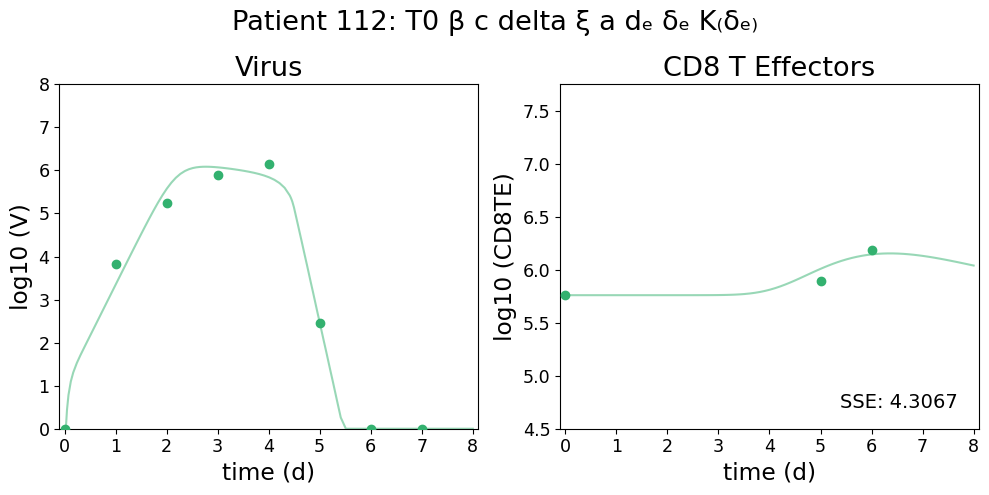

204 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 0.7146519204749158
differential_evolution step 2: f(x)= 0.7146519204749158
differential_evolution step 3: f(x)= 0.4010276188251848
differential_evolution step 4: f(x)= 0.4010276188251848
differential_evolution step 5: f(x)= 0.4010276188251848
differential_evolution step 6: f(x)= 0.4010276188251848
differential_evolution step 7: f(x)= 0.4010276188251848
differential_evolution step 8: f(x)= 0.4010276188251848
differential_evolution step 9: f(x)= 0.3848793688930027
differential_evolution step 10: f(x)= 0.3607616384780347
differential_evolution step 11: f(x)= 0.3607616384780347
differential_evolution step 12: f(x)= 0.3607616384780347
differential_evolution step 13: f(x)= 0.3606678336742388
differential_evolution step 14: f(x)= 0.3606678336742388
differential_evolution step 15: f(x)= 0.3606678336742388
differential_evolution step 16: f(x)= 0.3606678336742388
differential_evolution step 17: f(x

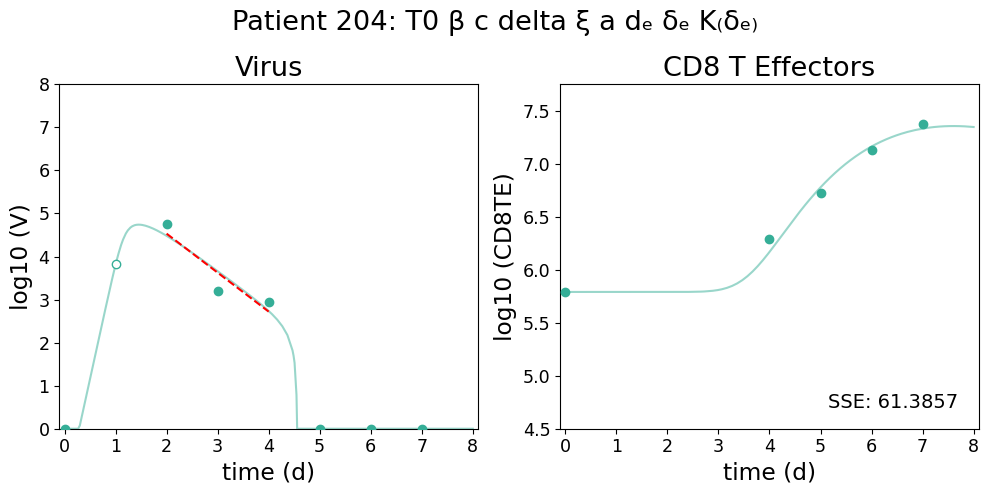

207 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.3569758634129534
differential_evolution step 2: f(x)= 1.3569758634129534
differential_evolution step 3: f(x)= 1.090647563256997
differential_evolution step 4: f(x)= 0.6778862989166712
differential_evolution step 5: f(x)= 0.6778862989166712
differential_evolution step 6: f(x)= 0.6778862989166712
differential_evolution step 7: f(x)= 0.6778862989166712
differential_evolution step 8: f(x)= 0.6778862989166712
differential_evolution step 9: f(x)= 0.6761913174999795
differential_evolution step 10: f(x)= 0.6761913174999795
differential_evolution step 11: f(x)= 0.5115563538451219
differential_evolution step 12: f(x)= 0.4198613307336917
differential_evolution step 13: f(x)= 0.3568997765469426
differential_evolution step 14: f(x)= 0.30286552662469085
differential_evolution step 15: f(x)= 0.2801781493385682
differential_evolution step 16: f(x)= 0.2758904378649213
differential_evolution step 17: f(x

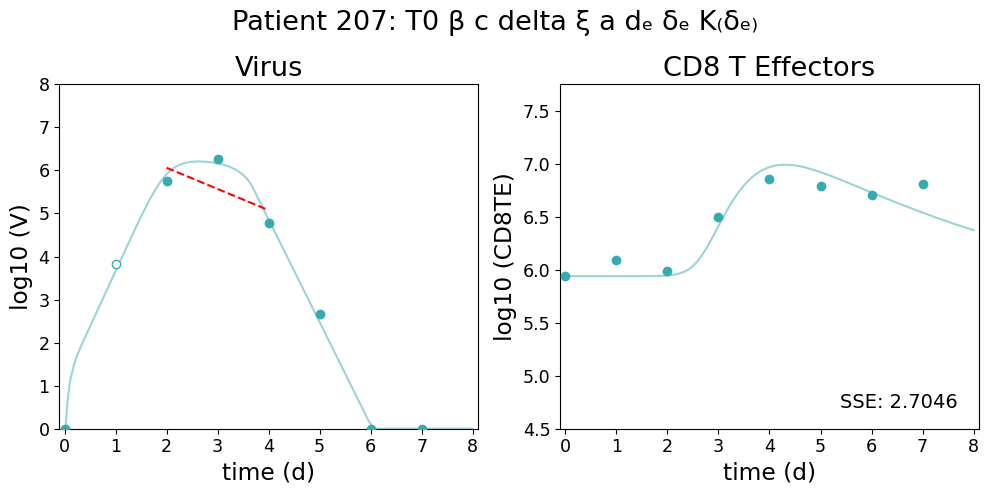

302 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.627317677805724
differential_evolution step 2: f(x)= 0.852935799166035
differential_evolution step 3: f(x)= 0.852935799166035
differential_evolution step 4: f(x)= 0.852935799166035
differential_evolution step 5: f(x)= 0.8223262268030732
differential_evolution step 6: f(x)= 0.8223262268030732
differential_evolution step 7: f(x)= 0.7053498346861926
differential_evolution step 8: f(x)= 0.7053498346861926
differential_evolution step 9: f(x)= 0.6247352712563898
differential_evolution step 10: f(x)= 0.6247352712563898
differential_evolution step 11: f(x)= 0.6247352712563898
differential_evolution step 12: f(x)= 0.5926921537171751
differential_evolution step 13: f(x)= 0.5926921537171751
differential_evolution step 14: f(x)= 0.5926921537171751
differential_evolution step 15: f(x)= 0.5623445813580629
differential_evolution step 16: f(x)= 0.5536022648807754
differential_evolution step 17: f(x)= 0

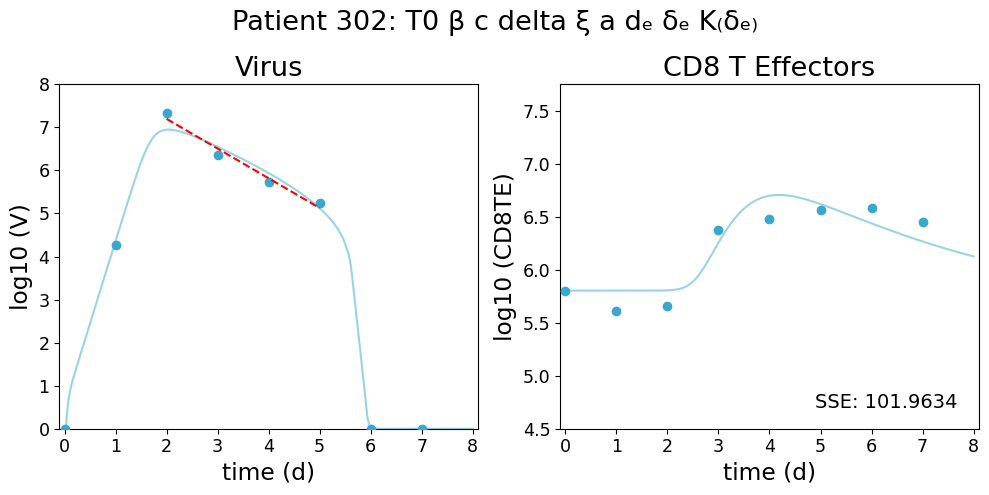

307 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.4840105193065358
differential_evolution step 2: f(x)= 1.4840105193065358
differential_evolution step 3: f(x)= 1.0881673133664165
differential_evolution step 4: f(x)= 1.0678972972237568
differential_evolution step 5: f(x)= 0.946616005521755
differential_evolution step 6: f(x)= 0.9061548624031743
differential_evolution step 7: f(x)= 0.9061548624031743
differential_evolution step 8: f(x)= 0.8908740628205845
differential_evolution step 9: f(x)= 0.8895539693574237
differential_evolution step 10: f(x)= 0.8895539693574237
differential_evolution step 11: f(x)= 0.8895539693574237
differential_evolution step 12: f(x)= 0.8850841058372706
differential_evolution step 13: f(x)= 0.8543289456742774
differential_evolution step 14: f(x)= 0.8500092329081881
differential_evolution step 15: f(x)= 0.8500092329081881
differential_evolution step 16: f(x)= 0.8500092329081881
differential_evolution step 17: f(x)

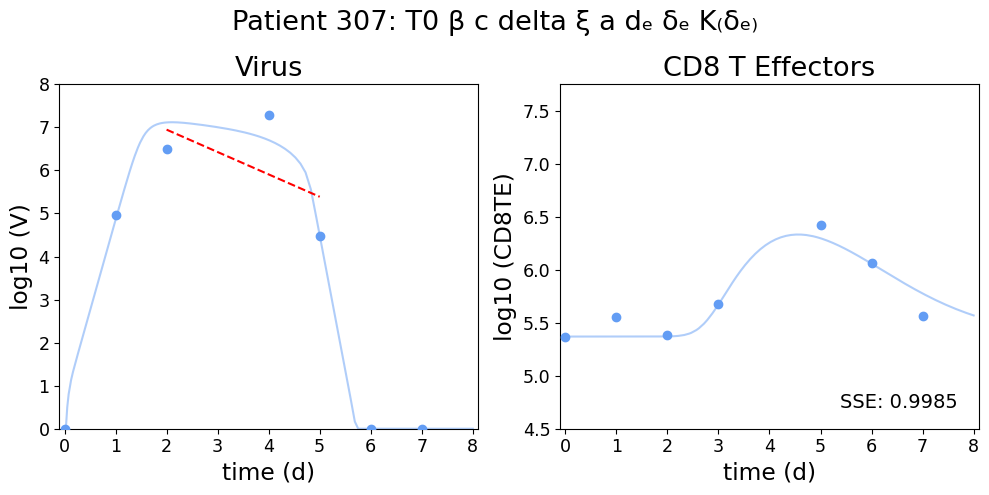

308 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 3.8350592291882264
differential_evolution step 2: f(x)= 3.00865936066009
differential_evolution step 3: f(x)= 3.00865936066009
differential_evolution step 4: f(x)= 2.865687552224015
differential_evolution step 5: f(x)= 2.1385771928929795
differential_evolution step 6: f(x)= 2.1385771928929795
differential_evolution step 7: f(x)= 2.1385771928929795
differential_evolution step 8: f(x)= 2.0315009064296445
differential_evolution step 9: f(x)= 2.0315009064296445
differential_evolution step 10: f(x)= 1.9598763498598395
differential_evolution step 11: f(x)= 1.9538025685716378
differential_evolution step 12: f(x)= 1.9538025685716378
differential_evolution step 13: f(x)= 1.9538025685716378
differential_evolution step 14: f(x)= 1.936355667125748
differential_evolution step 15: f(x)= 1.9307187398352004
differential_evolution step 16: f(x)= 1.9307187398352004
differential_evolution step 17: f(x)= 1.9

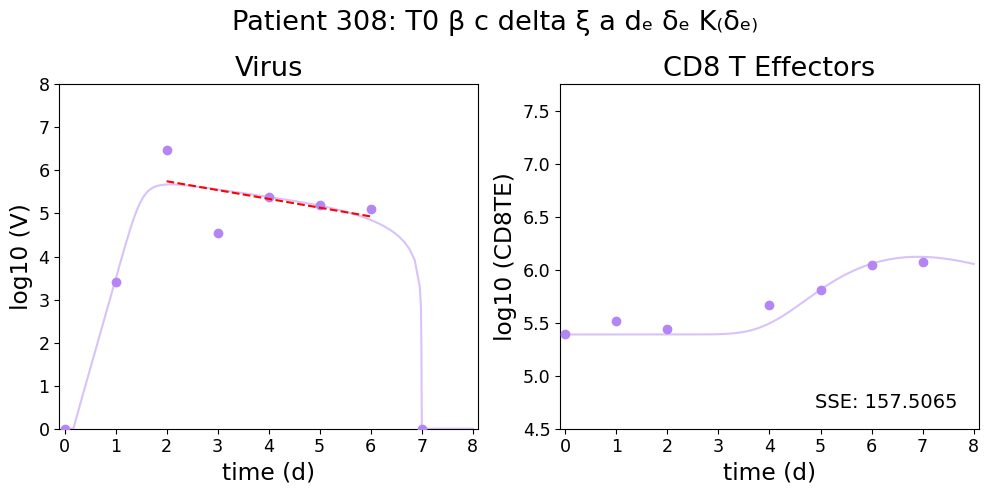

311 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 0.8618706313954363
differential_evolution step 2: f(x)= 0.5593598756186837
differential_evolution step 3: f(x)= 0.42220248083674805
differential_evolution step 4: f(x)= 0.42220248083674805
differential_evolution step 5: f(x)= 0.42086760879141305
differential_evolution step 6: f(x)= 0.42086760879141305
differential_evolution step 7: f(x)= 0.2676475296011709
differential_evolution step 8: f(x)= 0.2676475296011709
differential_evolution step 9: f(x)= 0.2676475296011709
differential_evolution step 10: f(x)= 0.26661690057338433
differential_evolution step 11: f(x)= 0.26661690057338433
differential_evolution step 12: f(x)= 0.26366535716283107
differential_evolution step 13: f(x)= 0.26119043225334015
differential_evolution step 14: f(x)= 0.2589423657897926
differential_evolution step 15: f(x)= 0.2589423657897926
differential_evolution step 16: f(x)= 0.2586712100652156
differential_evolution step

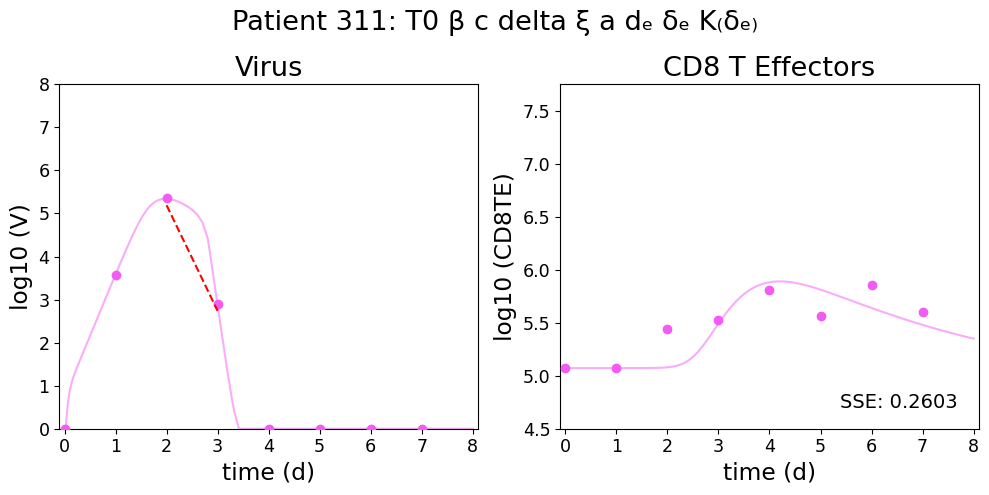

312 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 8.454453893081169
differential_evolution step 2: f(x)= 6.533587840246453
differential_evolution step 3: f(x)= 5.034921131549123
differential_evolution step 4: f(x)= 4.5141467039652
differential_evolution step 5: f(x)= 3.8157604963129934
differential_evolution step 6: f(x)= 3.8157604963129934
differential_evolution step 7: f(x)= 3.8157604963129934
differential_evolution step 8: f(x)= 3.8157604963129934
differential_evolution step 9: f(x)= 3.6727814948933437
differential_evolution step 10: f(x)= 3.6727814948933437
differential_evolution step 11: f(x)= 3.5790708806057494
differential_evolution step 12: f(x)= 3.5765990612609975
differential_evolution step 13: f(x)= 3.574754047671535
differential_evolution step 14: f(x)= 3.574754047671535
differential_evolution step 15: f(x)= 3.5404166768964047
differential_evolution step 16: f(x)= 3.5404166768964047
differential_evolution step 17: f(x)= 3.540

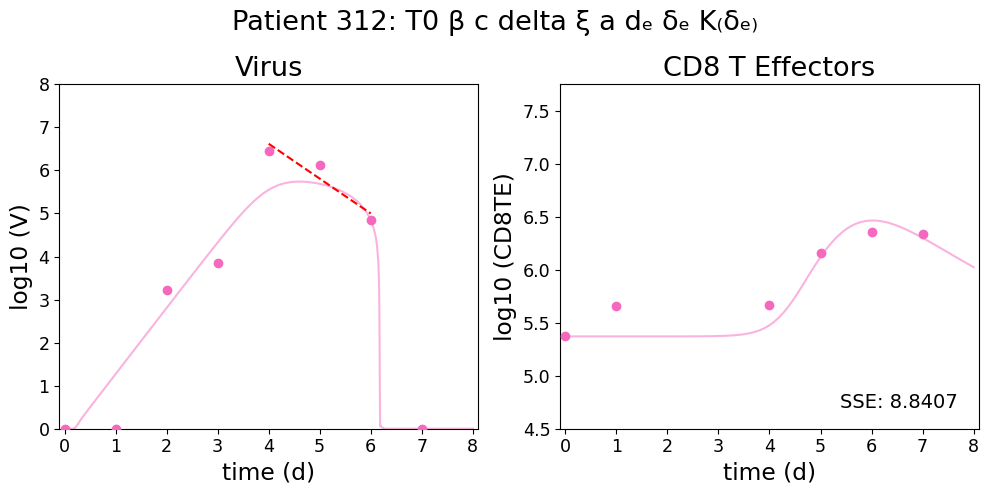

In [6]:
# LCT Model, Dose (T0 + 8 others)
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=1.1E5, u_lim=8.9E5, method='file', space='log10'), 
    T0=Parameter(name='T0', val=4E7, l_lim=1E4, u_lim=4E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-7, u_lim=1E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=10, l_lim=5E-2, u_lim=1E3, method='fixed', space='log10'), 
    c=Parameter(name='c', val=13.934, l_lim=5.0, u_lim=5E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=1E2, method='fit', space='log10'), 
    a=Parameter(name='a', val=2.5, l_lim=1.0, u_lim=10, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.55, u_lim=1.0, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
)


patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in ids:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=10000, verbose=True, path='Dose_Full')

    plot(results, subplot_configuration, title=None, group=False, save=True)

Population Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 252.8247813954978
differential_evolution step 2: f(x)= 246.96951954596412
differential_evolution step 3: f(x)= 239.34878542804475
differential_evolution step 4: f(x)= 238.01566075328736
differential_evolution step 5: f(x)= 237.09899706861282
differential_evolution step 6: f(x)= 237.02509505905473
differential_evolution step 7: f(x)= 236.97974035876464
differential_evolution step 8: f(x)= 236.97974035876464
differential_evolution step 9: f(x)= 236.95447595241734
Results saved to sql/Dose_Reduced.db.
Parameter T0: 1223625.3401735856
Parameter beta: 5.7884423561505954e-05
Parameter c: 357.27510718558096
Parameter delta: 0.6516032831897413


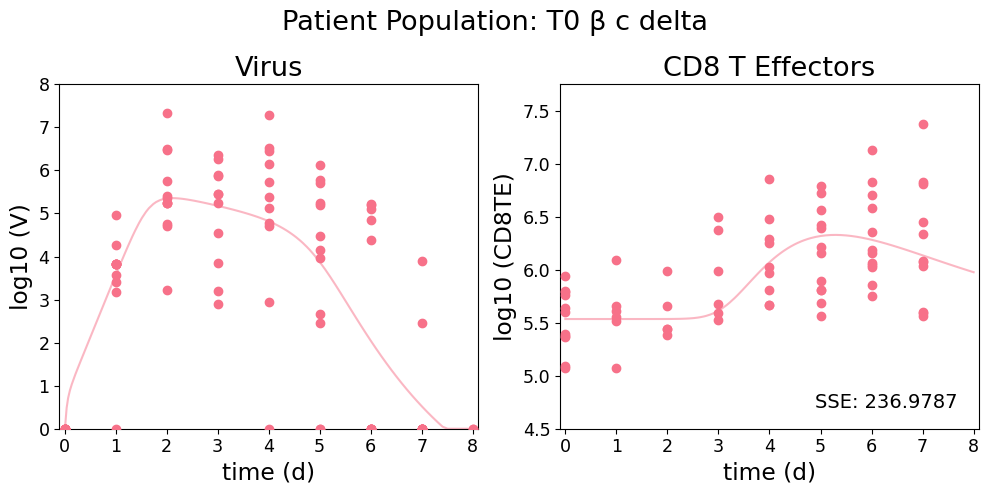

103 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 4.574607985785273
differential_evolution step 2: f(x)= 4.574607985785273
differential_evolution step 3: f(x)= 4.574607985785273
differential_evolution step 4: f(x)= 4.444552801767657
differential_evolution step 5: f(x)= 3.720753400328814
differential_evolution step 6: f(x)= 3.6370803653008523
differential_evolution step 7: f(x)= 3.5369201575949596
differential_evolution step 8: f(x)= 3.5369201575949596
differential_evolution step 9: f(x)= 3.5369201575949596
differential_evolution step 10: f(x)= 3.445044000353931
differential_evolution step 11: f(x)= 3.445044000353931
differential_evolution step 12: f(x)= 3.445044000353931
differential_evolution step 13: f(x)= 3.439410858661641
differential_evolution step 14: f(x)= 3.439410858661641
differential_evolution step 15: f(x)= 3.439410858661641
differential_evolution step 16: f(x)= 3.438634229799148
differential_evolution step 17: f(x)= 3.4371937

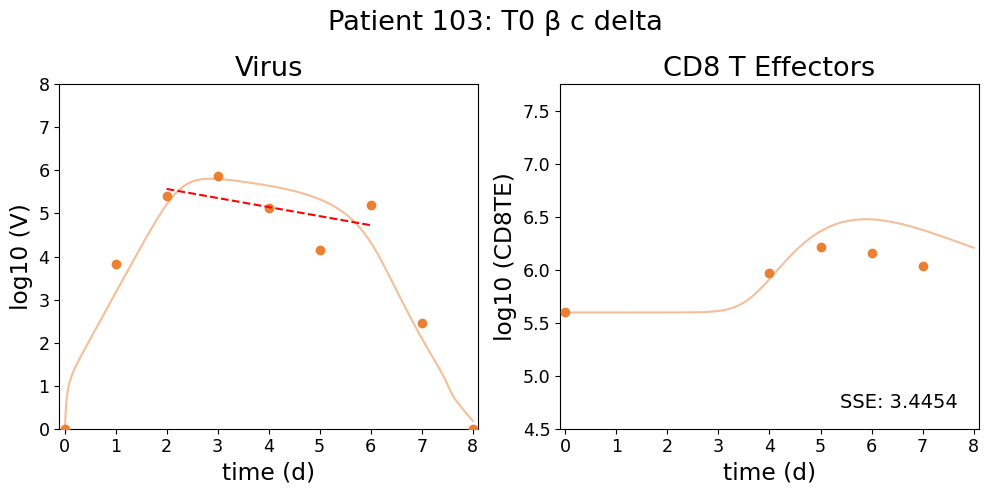

107 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.890386656119179
differential_evolution step 2: f(x)= 2.192826075200765
differential_evolution step 3: f(x)= 1.9327069907581902
differential_evolution step 4: f(x)= 1.9327069907581902
differential_evolution step 5: f(x)= 1.9327069907581902
differential_evolution step 6: f(x)= 1.8974332639439773
differential_evolution step 7: f(x)= 1.8881993824358168
differential_evolution step 8: f(x)= 1.8820813204550768
differential_evolution step 9: f(x)= 1.88016115847527
differential_evolution step 10: f(x)= 1.88016115847527
differential_evolution step 11: f(x)= 1.88016115847527
differential_evolution step 12: f(x)= 1.880035420965648
differential_evolution step 13: f(x)= 1.8799575856374902
Results saved to sql/Dose_Reduced.db.
Parameter T0: 3005129.4066925533
Parameter beta: 2.9015300567745717e-06
Parameter c: 93.0585518791381
Parameter delta: 1.033139612536213


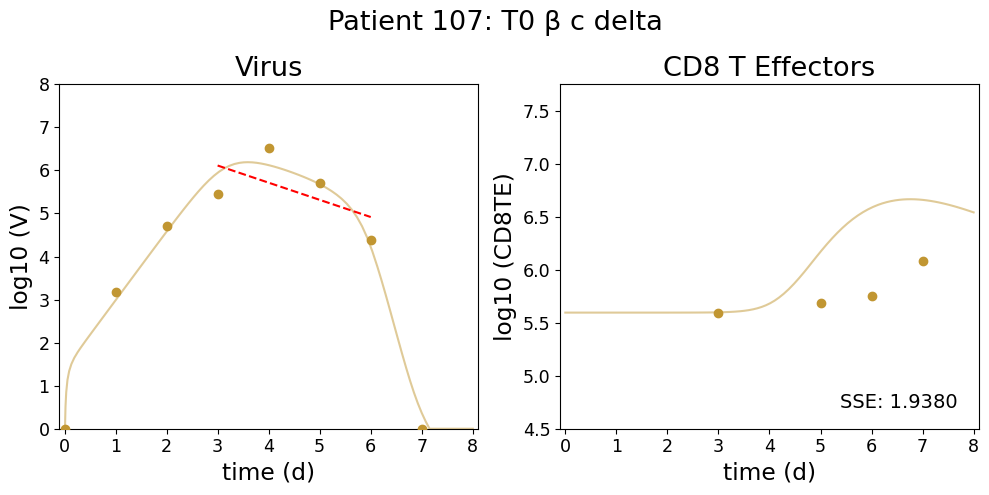

110 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 3.0863238967047786
differential_evolution step 2: f(x)= 3.0863238967047786
differential_evolution step 3: f(x)= 3.0863238967047786
differential_evolution step 4: f(x)= 3.0863238967047786
differential_evolution step 5: f(x)= 1.8946779050847917
differential_evolution step 6: f(x)= 1.8946779050847917
differential_evolution step 7: f(x)= 1.8946779050847917
differential_evolution step 8: f(x)= 1.8505316627759558
differential_evolution step 9: f(x)= 1.8505316627759558
differential_evolution step 10: f(x)= 1.8366556172246526
differential_evolution step 11: f(x)= 1.8366556172246526
differential_evolution step 12: f(x)= 1.8165493713643341
differential_evolution step 13: f(x)= 1.8165493713643341
differential_evolution step 14: f(x)= 1.8051828651454096
differential_evolution step 15: f(x)= 1.7936012676215933
differential_evolution step 16: f(x)= 1.7922143530707015
differential_evolution step 17: f(x

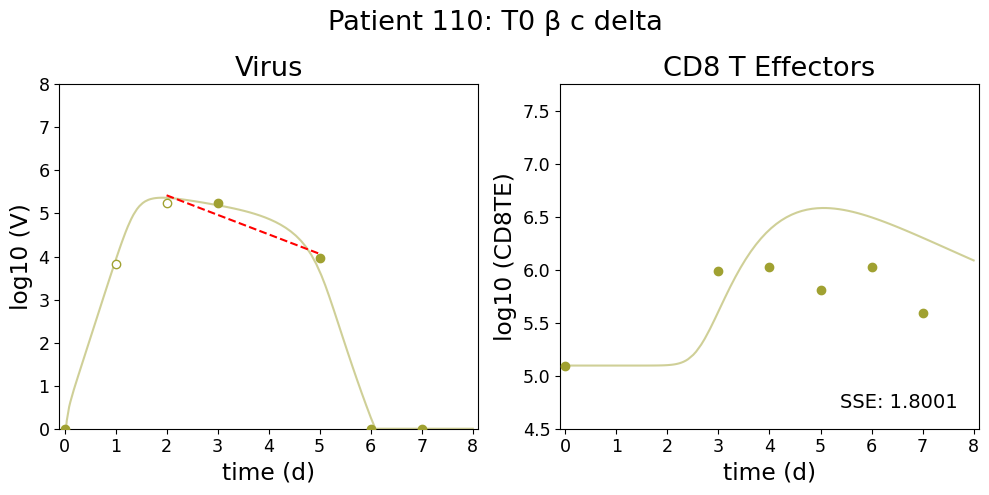

111 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 9.533922032723757
differential_evolution step 2: f(x)= 7.850193222396557
differential_evolution step 3: f(x)= 6.762904637010941
differential_evolution step 4: f(x)= 4.938102920316001
differential_evolution step 5: f(x)= 4.938102920316001
differential_evolution step 6: f(x)= 4.838029429007451
differential_evolution step 7: f(x)= 4.829316815709602
differential_evolution step 8: f(x)= 4.482786485509093
differential_evolution step 9: f(x)= 4.3775490296275805
differential_evolution step 10: f(x)= 4.230178199640257
differential_evolution step 11: f(x)= 4.230178199640257
differential_evolution step 12: f(x)= 4.186965697430367
differential_evolution step 13: f(x)= 4.186965697430367
differential_evolution step 14: f(x)= 4.186965697430367
differential_evolution step 15: f(x)= 4.182421458688654
differential_evolution step 16: f(x)= 4.17340672862606
differential_evolution step 17: f(x)= 4.17340672862

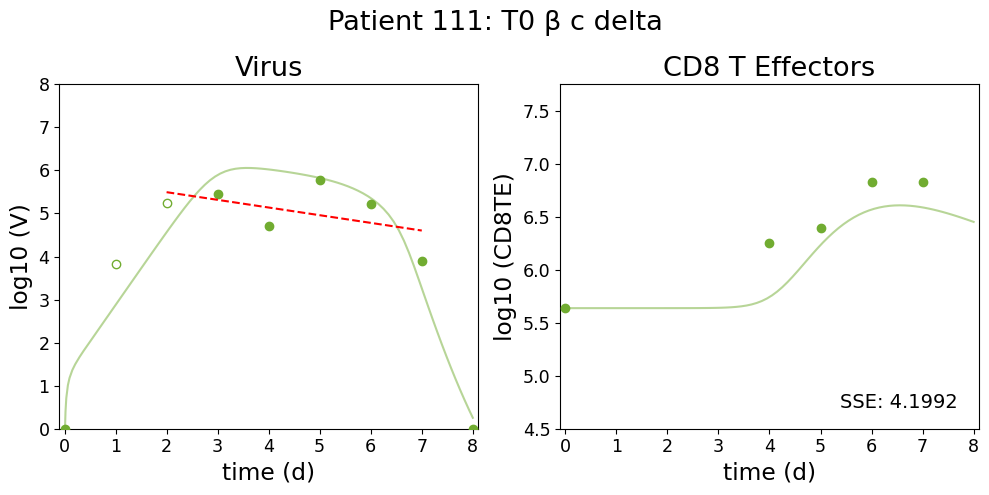

112 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.392918841882306
differential_evolution step 2: f(x)= 2.0859278697168153
differential_evolution step 3: f(x)= 2.0707882194866563
differential_evolution step 4: f(x)= 2.0609753804057016
differential_evolution step 5: f(x)= 2.0590035790348624
differential_evolution step 6: f(x)= 2.0564452117486365
differential_evolution step 7: f(x)= 2.0544901463024194
differential_evolution step 8: f(x)= 2.0544901463024194
differential_evolution step 9: f(x)= 2.0544901463024194
Results saved to sql/Dose_Reduced.db.
Parameter T0: 3435485.8643039237
Parameter beta: 3.6085894262993965e-06
Parameter c: 69.8299446148166
Parameter delta: 2.1584185331835317


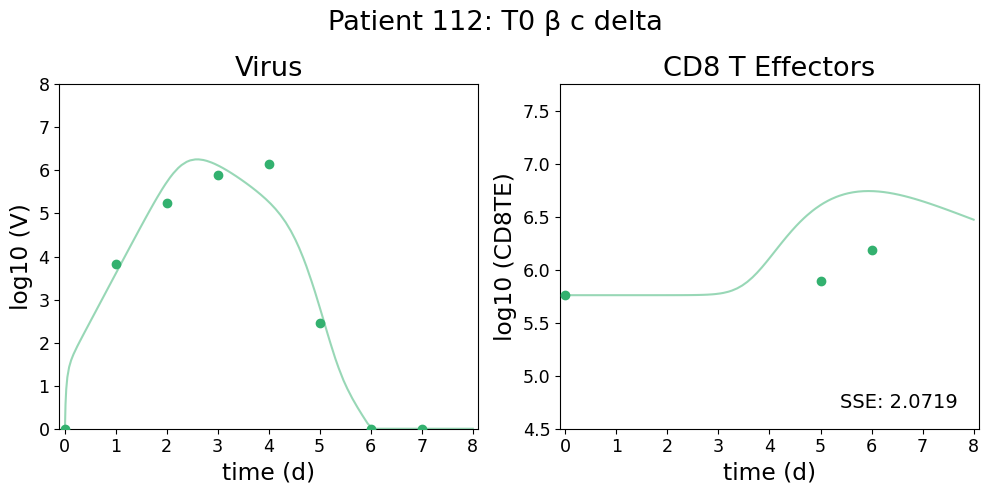

204 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 2.1288887575595083
differential_evolution step 2: f(x)= 2.1288887575595083
differential_evolution step 3: f(x)= 2.1288887575595083
differential_evolution step 4: f(x)= 2.1288887575595083
differential_evolution step 5: f(x)= 2.1288887575595083
differential_evolution step 6: f(x)= 2.0432139514183736
differential_evolution step 7: f(x)= 1.9866452569173378
differential_evolution step 8: f(x)= 1.944672826451729
differential_evolution step 9: f(x)= 1.944672826451729
differential_evolution step 10: f(x)= 1.9409989600583866
differential_evolution step 11: f(x)= 1.940038756888514
differential_evolution step 12: f(x)= 1.9400351105587879
differential_evolution step 13: f(x)= 1.9383377086287075
differential_evolution step 14: f(x)= 1.9372250354573795
differential_evolution step 15: f(x)= 1.937042515462585
differential_evolution step 16: f(x)= 1.9368326698106697
differential_evolution step 17: f(x)= 1

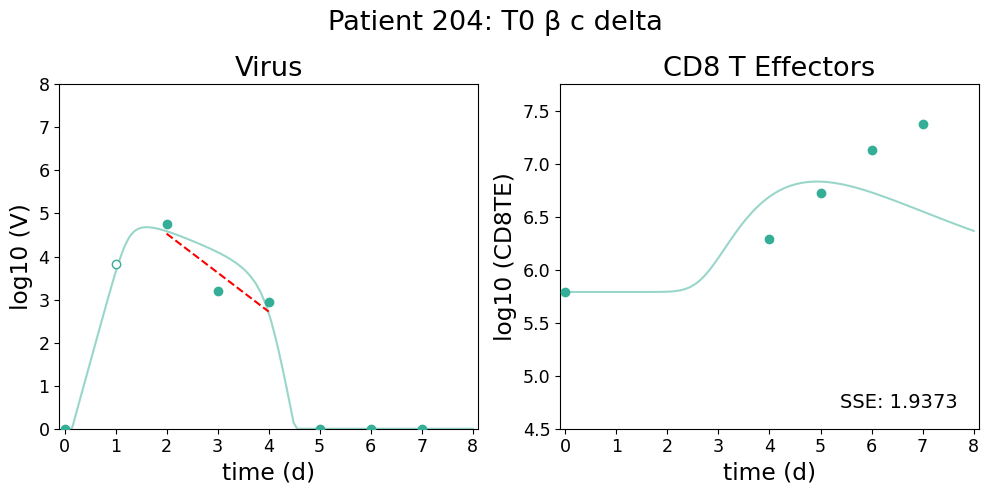

207 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 1.0275603663004058
differential_evolution step 2: f(x)= 1.0275603663004058
differential_evolution step 3: f(x)= 0.9669952738596905
differential_evolution step 4: f(x)= 0.9489197091866033
differential_evolution step 5: f(x)= 0.9489197091866033
differential_evolution step 6: f(x)= 0.9457469072313668
differential_evolution step 7: f(x)= 0.9457469072313668
differential_evolution step 8: f(x)= 0.9454339300471056
differential_evolution step 9: f(x)= 0.9454339300471056
differential_evolution step 10: f(x)= 0.9454339300471056
Results saved to sql/Dose_Reduced.db.
Parameter T0: 5257382.993161446
Parameter beta: 2.6279642279300932e-05
Parameter c: 532.7016330184465
Parameter delta: 0.6296726219447728


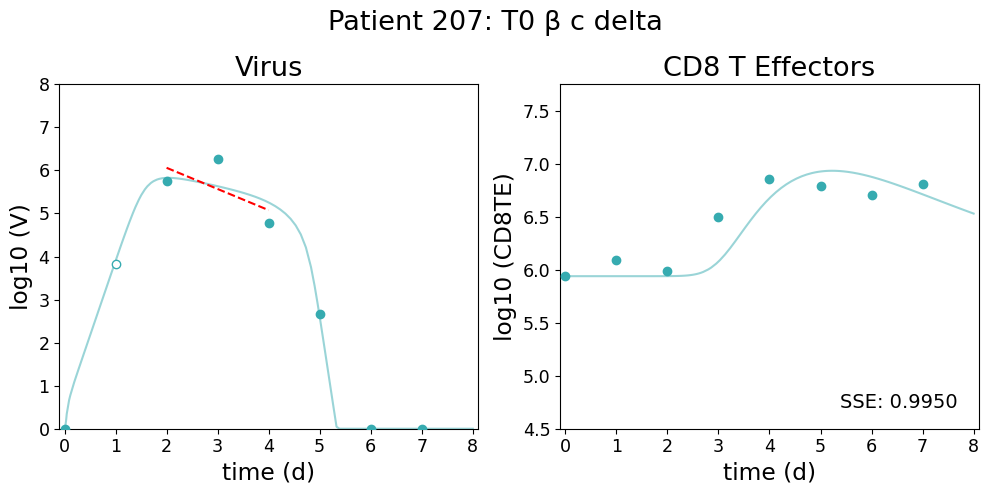

302 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 3.4424318259560427
differential_evolution step 2: f(x)= 1.6327740409990081
differential_evolution step 3: f(x)= 1.5986945998551634
differential_evolution step 4: f(x)= 1.4562072881989856
differential_evolution step 5: f(x)= 1.3443005858538513
differential_evolution step 6: f(x)= 1.2975537886967887
differential_evolution step 7: f(x)= 1.2975537886967887
differential_evolution step 8: f(x)= 1.2975537886967887
differential_evolution step 9: f(x)= 1.2954508211783788
differential_evolution step 10: f(x)= 1.2951020788430994
differential_evolution step 11: f(x)= 1.2936348953390766
differential_evolution step 12: f(x)= 1.2923965489102907
Results saved to sql/Dose_Reduced.db.
Parameter T0: 3671160.379316107
Parameter beta: 3.4026707050523017e-06
Parameter c: 52.94209187337298
Parameter delta: 0.5917263079802676


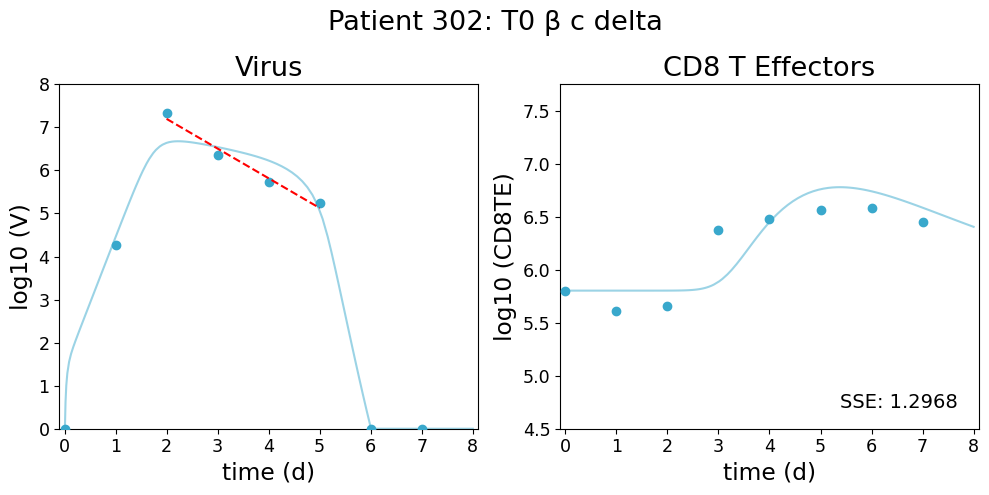

307 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 5.164633611213584
differential_evolution step 2: f(x)= 3.4381458150605715
differential_evolution step 3: f(x)= 2.3766755099969568
differential_evolution step 4: f(x)= 2.3348246126840255
differential_evolution step 5: f(x)= 2.23597159407439
differential_evolution step 6: f(x)= 2.23597159407439
differential_evolution step 7: f(x)= 2.2318959274767414
differential_evolution step 8: f(x)= 2.2318959274767414
differential_evolution step 9: f(x)= 2.2283897150951897
differential_evolution step 10: f(x)= 2.2176128406073885
differential_evolution step 11: f(x)= 2.2176128406073885
differential_evolution step 12: f(x)= 2.2139292545580505
Results saved to sql/Dose_Reduced.db.
Parameter T0: 3072366.861871883
Parameter beta: 1.9162257343881884e-06
Parameter c: 16.569418413991414
Parameter delta: 0.7203843000898068


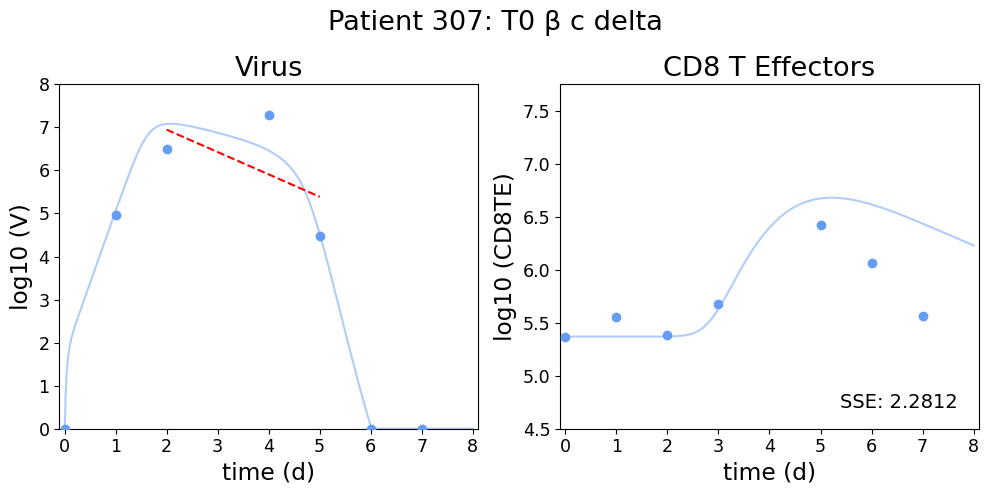

308 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 10.335502132276188
differential_evolution step 2: f(x)= 6.722787478293949
differential_evolution step 3: f(x)= 6.722787478293949
differential_evolution step 4: f(x)= 6.722787478293949
differential_evolution step 5: f(x)= 6.373888186158185
differential_evolution step 6: f(x)= 6.373888186158185
differential_evolution step 7: f(x)= 6.089346075740767
differential_evolution step 8: f(x)= 6.037959303942527
differential_evolution step 9: f(x)= 5.981006487855725
differential_evolution step 10: f(x)= 5.9757267679312
differential_evolution step 11: f(x)= 5.9757267679312
differential_evolution step 12: f(x)= 5.9757267679312
differential_evolution step 13: f(x)= 5.9757267679312
differential_evolution step 14: f(x)= 5.960568211401492
differential_evolution step 15: f(x)= 5.959958128649797
differential_evolution step 16: f(x)= 5.959018537814819
differential_evolution step 17: f(x)= 5.951235574844734
di

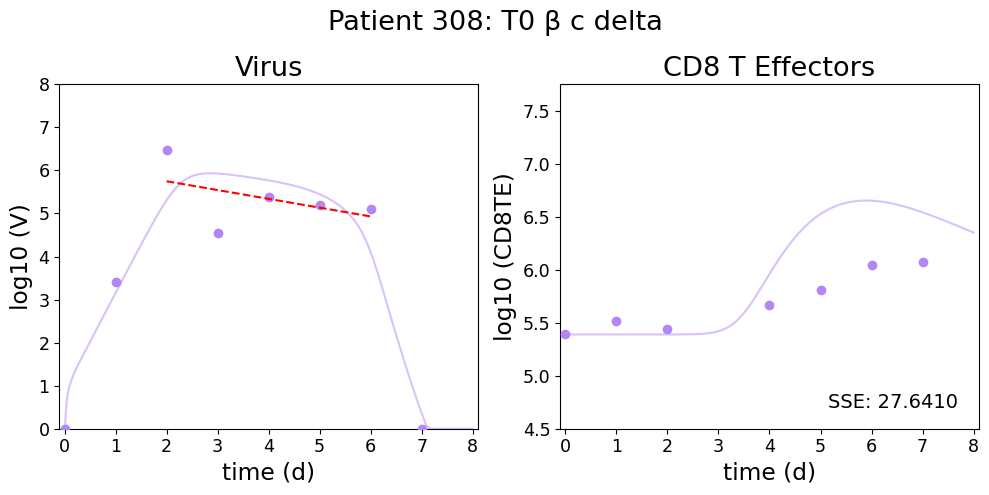

311 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 4.496095492493193
differential_evolution step 2: f(x)= 4.48739376240847
differential_evolution step 3: f(x)= 4.408949122197964
differential_evolution step 4: f(x)= 4.408949122197964
differential_evolution step 5: f(x)= 4.404810140777564
differential_evolution step 6: f(x)= 4.4010006634911045
differential_evolution step 7: f(x)= 4.360447420525649
differential_evolution step 8: f(x)= 4.351827740715687
differential_evolution step 9: f(x)= 4.351827740715687
differential_evolution step 10: f(x)= 4.351827740715687
differential_evolution step 11: f(x)= 4.351827740715687
differential_evolution step 12: f(x)= 4.3490392145056695
Results saved to sql/Dose_Reduced.db.
Parameter T0: 1316088.606497566
Parameter beta: 0.009868397346200522
Parameter c: 1029.4082405720894
Parameter delta: 1.6324186676974146


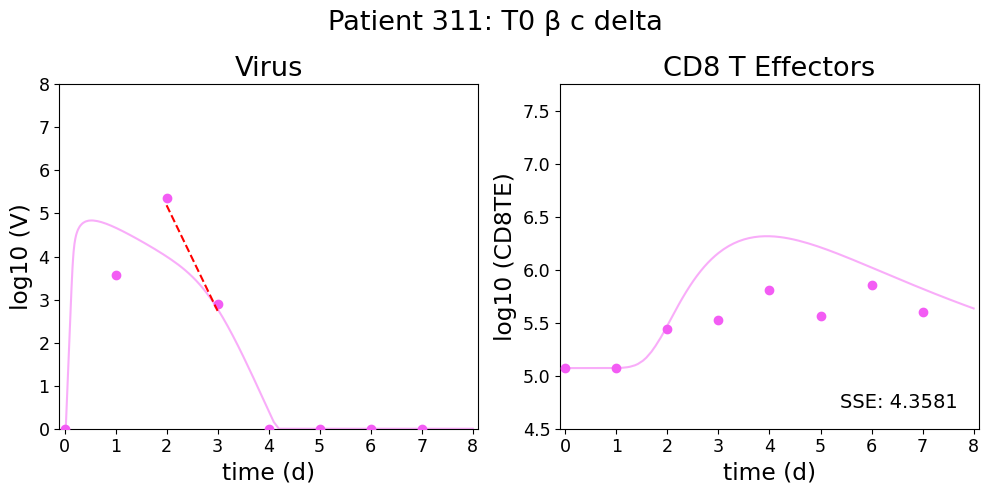

312 Differential Evolution with pop size:100, generations:100
differential_evolution step 1: f(x)= 7.171537552445815
differential_evolution step 2: f(x)= 6.3099523813106035
differential_evolution step 3: f(x)= 6.258459098322123
differential_evolution step 4: f(x)= 6.188779089018552
differential_evolution step 5: f(x)= 6.005907512786316
differential_evolution step 6: f(x)= 6.005907512786316
differential_evolution step 7: f(x)= 6.005907512786316
differential_evolution step 8: f(x)= 6.005907512786316
differential_evolution step 9: f(x)= 6.005907512786316
differential_evolution step 10: f(x)= 5.9508779756644
differential_evolution step 11: f(x)= 5.9508779756644
differential_evolution step 12: f(x)= 5.931876732768153
differential_evolution step 13: f(x)= 5.930961696786905
differential_evolution step 14: f(x)= 5.930961696786905
Results saved to sql/Dose_Reduced.db.
Parameter T0: 15083273.784680925
Parameter beta: 1.3045730647227306e-05
Parameter c: 2558.714775518978
Parameter delta: 0.790228

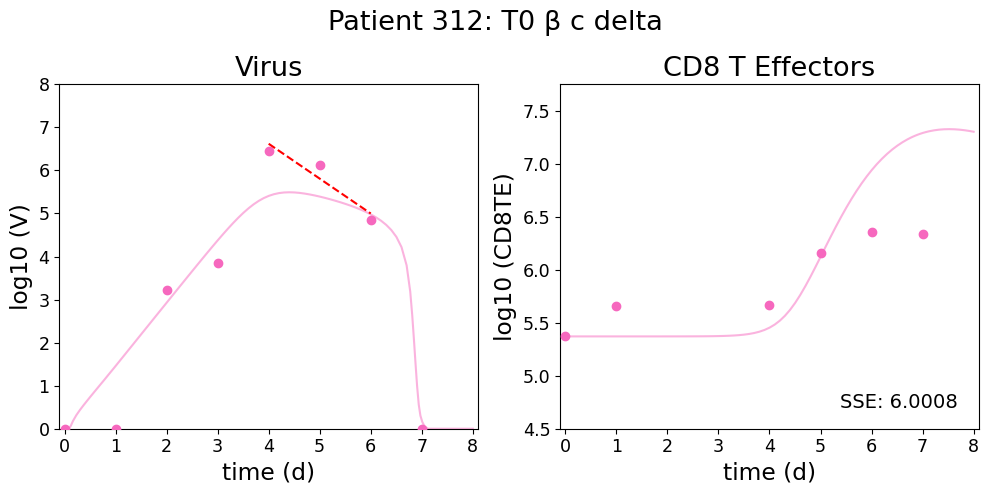

In [9]:
# LCT Model, Dose, fixed Population T cell parameters, fit T0, beta, c, delta (mmatch Reduced Dose Model in DOF)
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=1.1E5, u_lim=8.9E5, method='file', space='log10'), 
    T0=Parameter(name='T0', val=4E7, l_lim=1E4, u_lim=4E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-7, u_lim=1E-2, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=100, l_lim=5E-2, u_lim=1E3, method='fixed', space='log10'), 
    c=Parameter(name='c', val=13.934, l_lim=5.0, u_lim=5E3, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=12.0211375924785, l_lim=1E-2, u_lim=1E2, method='fixed', space='log10'), 
    a=Parameter(name='a', val=4.64234366738454, l_lim=1.0, u_lim=10, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=0.550820961050752, l_lim=0.75, u_lim=1.25, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=0.2028420788589, l_lim=1E-1, u_lim=10, method='fixed', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=93093.6115567915, l_lim=1E1, u_lim=1E6, method='fixed', space='log10'),
)


patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in ids:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=10000, verbose=True, path='Dose_Reduced')

    plot(results, subplot_configuration, title=None, group=False, save=True)